In [5]:
# 7. Test semantic correction on a sample text
def test_semantic_correction():
    """Test the semantic correction function with some sample OCR errors"""
    test_cases = [
        "This is a playstation game",
        "Found a PIay5tation controller at the store",
        "X80X games on sale",
        "The game works on X-box",
        "The game is available on P C",
        "This is a special Nlntend0 edition",
        "Nintemdo Switch game",
        "Designed for Playststion and XB0X",
        "This works on Stearn for PC users",
        "Compatible with plehstatien"
    ]
    
    print("Testing semantic correction functionality:")
    print("==========================================")
    for text in test_cases:
        corrected = correct_platform_references(text)
        if text.lower() != corrected.lower():
            print(f"Original: {text}")
            print(f"Corrected: {corrected}")
            
            # Find what platform was detected
            platforms_found = []
            for platform in gaming_platforms.keys():
                if platform in corrected.lower():
                    platforms_found.append(platform)
            
            print(f"Platform(s) detected: {', '.join(platforms_found)}")
            print("---")
        else:
            print(f"No correction needed: {text}")
            print("---")
    print()# Recommend the best filter based on evaluation metrics
def recommend_filters_with_metrics(results_df):
    """Recommend the best filter or combination of filters based on evaluation metrics"""
    if results_df is None or results_df.empty:
        print("No results for recommendations")
        return
    
    # Check if we have evaluation metrics
    has_metrics = all(col in results_df.columns for col in ['precision', 'recall', 'f1'])
    
    # Create a comprehensive score
    if has_metrics:
        # Score based primarily on F1 score, with secondary factors
        results_df['score'] = (
            0.6 * results_df['f1'] + 
            0.2 * results_df['precision'] + 
            0.2 * results_df['recall']
        )
    else:
        # Fallback to previous scoring method
        results_df['score'] = (
            0.5 * (results_df['platform_count'] / results_df['platform_count'].max()) + 
            0.3 * (results_df['total_numbers'] / results_df['total_numbers'].max()) + 
            0.2 * (results_df['avg_text_length'] / results_df['avg_text_length'].max())
        )
    
    # Sort by score
    results_df = results_df.sort_values('score', ascending=False)
    
    print("Best Filters Recommendation:")
    print("============================")
    print("\nTop 5 individual filters:")
    for i, (filter_name, row) in enumerate(results_df.head(5).iterrows()):
        print(f"{i+1}. {filter_name} (Score: {row['score']:.2f})")
        
        if has_metrics:
            print(f"   - F1 Score: {row['f1']:.3f}")
            print(f"   - Precision: {row['precision']:.3f}")
            print(f"   - Recall: {row['recall']:.3f}")
            print(f"   - Accuracy: {row['accuracy']:.3f}")
            print(f"   - Evaluated on: {row['evaluated_images']} labeled images")
        
        print(f"   - Gaming platforms detected: {row['platform_count']} ({row['platform_percentage']:.1f}%)")
        print(f"   - Numbers extracted: {row['total_numbers']} (avg {row['avg_numbers_per_image']:.1f} per image)")
        
        if 'avg_processing_time' in row and not pd.isna(row['avg_processing_time']):
            print(f"   - Average processing time: {row['avg_processing_time']:.2f} seconds")
        print()
    
    # Find potential complementary filters
    best_filter = results_df.index[0]
    complementary_filters = []
    
    for filter_name in results_df.index[1:6]:  # Check the next 5 filters
        if 'adaptive' in best_filter and 'otsu' in filter_name:
            complementary_filters.append(filter_name)
        elif 'sharpen' in best_filter and 'denoise' in filter_name:
            complementary_filters.append(filter_name)
        elif 'contrast' in best_filter and 'clahe' in filter_name:
            complementary_filters.append(filter_name)
        elif 'canny' in best_filter and 'contours' in filter_name:
            complementary_filters.append(filter_name)
    
    if complementary_filters:
        print("\nRecommended filter combinations:")
        for i, comp_filter in enumerate(complementary_filters):
            print(f"{i+1}. {best_filter} + {comp_filter}")
    
    # Final recommendation
    print("\nFinal Recommendation:")
    if has_metrics:
        print(f"The best preprocessing approach based on F1 score is: {best_filter}")
    else:
        print(f"The best preprocessing approach appears to be: {best_filter}")
        
    if complementary_filters:
        print(f"Consider also testing a combined approach with: {complementary_filters[0]}")
    
    return results_df# Visualize evaluation metrics




    
def visualize_metrics(results_df):
    """Create visualizations for evaluation metrics"""
    if results_df is None or results_df.empty:
        print("No results to visualize")
        return
    
    # Check if we have evaluation metrics
    if 'precision' not in results_df.columns:
        print("No evaluation metrics available")
        return
    
    # 1. Precision, Recall, F1 bar chart
    plt.figure(figsize=(14, 8))
    metrics_df = results_df[['precision', 'recall', 'f1']].sort_values('f1', ascending=False).head(10)
    metrics_df.plot(kind='bar')
    plt.title('Precision, Recall, and F1 Scores by Filter')
    plt.ylabel('Score')
    plt.xlabel('Preprocessing Filter')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 2. Accuracy vs Platform Detection Rate - Fixed scatter plot
    plt.figure(figsize=(14, 8))
    
    # Make sure all values used in the scatter plot exist and are valid
    valid_indices = results_df.dropna(subset=['platform_percentage', 'accuracy', 'f1']).index
    
    plt.scatter(
        results_df.loc[valid_indices, 'platform_percentage'], 
        results_df.loc[valid_indices, 'accuracy'] * 100,
        s=results_df.loc[valid_indices, 'f1'] * 200,  # Size based on F1
        alpha=0.7
    )
    
    # Add labels for top 5 filters - ensure they exist in the valid indices
    top_filters = results_df.sort_values('f1', ascending=False).head(5).index
    top_filters = [f for f in top_filters if f in valid_indices]  # Filter to only valid indices
    
    for filter_name in top_filters:
        x = results_df.loc[filter_name, 'platform_percentage']
        y = results_df.loc[filter_name, 'accuracy'] * 100
        plt.annotate(
            filter_name,
            (x, y),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )
    
    plt.title('Accuracy vs Platform Detection Rate')
    plt.xlabel('Platform Detection Rate (%)')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 3. Confusion Matrix for the best filter
    if len(results_df) > 0:
        best_filter_candidates = results_df.sort_values('f1', ascending=False).index
        best_filter = None
        
        # Find the first best filter that has a valid confusion matrix
        for filter_name in best_filter_candidates:
            if ('confusion_matrix' in results_df.columns and 
                filter_name in results_df.index and 
                not pd.isna(results_df.loc[filter_name, 'confusion_matrix']).any()):
                best_filter = filter_name
                break
        
        if best_filter is not None:
            cm = results_df.loc[best_filter, 'confusion_matrix']
            labels = results_df.loc[best_filter, 'cm_labels']
            
            if cm is not None and labels is not None:
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
                plt.title(f'Confusion Matrix for {best_filter}')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                plt.tight_layout()
                plt.show()
            else:
                print("Confusion matrix not available for the best filter")
        else:
            print("No valid confusion matrix found for any filter")
            
    # 4. F1 Score Comparison
    plt.figure(figsize=(14, 8))
    
    # Ensure we have valid F1 scores
    valid_f1_indices = results_df.dropna(subset=['f1']).index
    if len(valid_f1_indices) > 0:
        top_10 = results_df.loc[valid_f1_indices].sort_values('f1', ascending=False).head(10)
        ax = top_10['f1'].plot(kind='bar', color='green')
        ax.set_title('F1 Score by Preprocessing Filter (Top 10)')
        ax.set_ylabel('F1 Score')
        ax.set_xlabel('Preprocessing Filter')
        plt.ylim(0, 1.0)
        for i, v in enumerate(top_10['f1']):
            ax.text(i, v + 0.02, f'{v:.2f}', ha='center')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No valid F1 scores to display")


# Modifications to make sure F1 scores are correctly calculated and displayed

# 1. Fix in calculate_metrics function - ensure we're handling zero division properly
def calculate_metrics(df, ground_truth_labels):
    """Calculate precision, recall, F1 score for platform detection"""
    if 'corrected_text' not in df.columns:
        df['corrected_text'] = df['extracted_text'].apply(correct_platform_references)
    
    # Create a new column with predicted platform labels
    df['predicted_platform'] = 'unknown'
    
    # For each row, determine which platform(s) were detected
    for _, row in df.iterrows():
        if not pd.isna(row['corrected_text']) and isinstance(row['corrected_text'], str):
            text = row['corrected_text'].lower()
            
            detected_platforms = []
            for platform in gaming_platforms.keys():
                if platform in text:
                    detected_platforms.append(platform)
            
            if detected_platforms:
                # If multiple platforms detected, take the first one
                df.loc[_, 'predicted_platform'] = detected_platforms[0]
    
    # Prepare for evaluation
    evaluation_data = []
    
    for _, row in df.iterrows():
        filename = row['filename']
        
        # Some filenames might have folders in them, extract just the filename
        if '/' in filename or '\\' in filename:
            filename = os.path.basename(filename)
        
        predicted = row['predicted_platform']
        
        # Check if this image has ground truth
        if filename in ground_truth_labels:
            true_label = ground_truth_labels[filename]
            evaluation_data.append({
                'filename': filename,
                'true_label': true_label,
                'predicted': predicted,
                'correct': predicted == true_label
            })
    
    # If no evaluation data, return empty metrics
    if not evaluation_data:
        return {
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'evaluated_images': 0,
            'confusion_matrix': None,
            'labels': []
        }
    
    # Convert to DataFrame for easier analysis
    eval_df = pd.DataFrame(evaluation_data)
    
    # Calculate metrics
    y_true = eval_df['true_label'].values
    y_pred = eval_df['predicted'].values
    
    # Get unique platforms for confusion matrix
    unique_platforms = list(set(y_true) | set(y_pred))
    
    # Calculate precision, recall, f1 per class
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=unique_platforms)
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        precision, recall, f1, accuracy = 0, 0, 0, 0
        cm = None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'evaluated_images': len(eval_df),
        'confusion_matrix': cm,
        'labels': unique_platforms
    }

# 2. Fix in analyze_results_with_metrics to ensure we're properly storing metrics
def analyze_results_with_metrics(dfs, ground_truth_labels):
    """Analyze the OCR results with evaluation metrics"""
    if not dfs:
        return None
    
    # Results dictionary
    results = {}
    
    for filter_name, df in dfs.items():
        # Skip if the DataFrame is empty
        if df.empty:
            continue
        
        # Clean filter name for display
        clean_filter_name = filter_name.split('_')[0].replace('ocr', '').strip()
        
        # Apply semantic correction to text
        df['corrected_text'] = df['extracted_text'].apply(correct_platform_references)
        
        # Calculate platform detection metrics
        metrics = calculate_metrics(df, ground_truth_labels)
        
        # Print metrics for debugging
        print(f"Metrics for {clean_filter_name}:")
        print(f"  F1: {metrics['f1']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
        print(f"  Evaluated on {metrics['evaluated_images']} images")
        
        # Check for gaming platforms using both original and corrected text
        df['has_gaming_platform_original'] = df['extracted_text'].apply(
            lambda x: any(platform in str(x).lower() for platform in gaming_platforms.keys()) if not pd.isna(x) else False
        )
        df['has_gaming_platform_corrected'] = df['corrected_text'].apply(
            lambda x: any(platform in str(x).lower() for platform in gaming_platforms.keys()) if not pd.isna(x) else False
        )
        
        # Count platforms detected before and after correction
        platform_count_original = df['has_gaming_platform_original'].sum()
        platform_count_corrected = df['has_gaming_platform_corrected'].sum()
        platform_improvement = platform_count_corrected - platform_count_original
        
        # Analyze platforms by type
        platform_types = {}
        for platform in gaming_platforms.keys():
            platform_types[platform] = df['corrected_text'].apply(
                lambda x: platform in str(x).lower() if not pd.isna(x) else False
            ).sum()
        
        # Extract numbers
        df['extracted_numbers'] = df['extracted_text'].apply(extract_numbers)
        df['number_count'] = df['extracted_numbers'].apply(len)
        total_numbers = df['number_count'].sum()
        
        # Text length metrics
        df['text_length'] = df['extracted_text'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)
        avg_text_length = df['text_length'].mean()
        
        # Processing time
        avg_processing_time = df['processing_time'].mean() if 'processing_time' in df.columns else 0
        
        # Compile results
        results[clean_filter_name] = {
            'platform_count': platform_count_corrected,  # Use corrected count
            'platform_count_original': platform_count_original,
            'platform_improvement': platform_improvement,
            'platform_percentage': (platform_count_corrected / len(df)) * 100,
            'total_numbers': total_numbers,
            'avg_numbers_per_image': total_numbers / len(df),
            'avg_text_length': avg_text_length,
            'avg_processing_time': avg_processing_time,
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1': metrics['f1'],
            'evaluated_images': metrics['evaluated_images'],
            'confusion_matrix': metrics['confusion_matrix'],
            'cm_labels': metrics['labels']
        }
        
        # Add platform-specific counts
        for platform, count in platform_types.items():
            results[clean_filter_name][f'platform_{platform}'] = count
    
    # Convert to DataFrame for easier visualization
    if not results:
        print("No results were generated. Check if any filters matched with labeled data.")
        return None
        
    results_df = pd.DataFrame(results).T
    
    # Sort by F1 score and print debug info
    results_df = results_df.sort_values(['f1', 'precision', 'recall'], ascending=False)
    print("\nSorted results by F1 score:")
    print(results_df[['f1', 'precision', 'recall', 'accuracy']].head())
    
    return results_df




def load_ground_truth_labels(directory="data/batchs_csv"):
    """Load all ground truth label files ending with _clean.csv"""
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    
    if not csv_files:
        print(f"No ground truth label files found in {directory}")
        return None
    
    print(f"Found {len(csv_files)} ground truth label files")
    
    # Create a dictionary to store all labels
    all_labels = {}
    
    for csv_file in csv_files:
        try:
            # Load the CSV file
            df = pd.read_csv(csv_file)
            
            # Check if it has the expected format (image_name, category, subcategory)
            if 'image_name' in df.columns and 'category' in df.columns:
                # Standardize the platform naming
                if 'category' in df.columns:
                    # Map category to standardized platform names
                    category_mapping = {
                        'PC Gaming': 'pc',
                        'PC': 'pc',
                        'PlayStation': 'playstation',
                        'Xbox': 'xbox',
                        'Nintendo': 'nintendo'
                    }
                    
                    # Apply mapping with fallback to lowercase
                    df['platform'] = df['category'].apply(
                        lambda x: category_mapping.get(x, x.lower()) if isinstance(x, str) else "unknown"
                    )
                
                # Add to the combined labels dictionary
                for _, row in df.iterrows():
                    if 'image_name' in row and 'platform' in row:
                        image_name = row['image_name']
                        platform = row['platform']
                        all_labels[image_name] = platform
            else:
                print(f"Warning: File {csv_file} does not have the expected columns")
                
        except Exception as e:
            print(f"Error loading {csv_file}: {str(e)}")
    
    print(f"Loaded {len(all_labels)} labeled images")
    return all_labels# OCR Results Comparison and Analysis
import os
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Configure plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Load all CSV files from the results directory
def load_all_csv_files(directory="ocr_results"):
    """Load all CSV files from the specified directory"""
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {directory}")
        return None
    
    print(f"Found {len(csv_files)} CSV files")
    
    # Create a dictionary to store dataframes
    dfs = {}
    
    for csv_file in csv_files:
        # Extract the filter name from the filename
        # Example filename: ocr_adaptive_thresholding_20240307_123456.csv
        filter_name = os.path.basename(csv_file).split('_', 2)[1]
        
        # Add timestamp to distinguish multiple runs of the same filter
        timestamp = os.path.basename(csv_file).split('_')[-2] + '_' + os.path.basename(csv_file).split('_')[-1].replace('.csv', '')
        
        # Create a key for the dictionary
        key = f"{filter_name}_{timestamp}"
        
        # Load the CSV file
        df = pd.read_csv(csv_file)
        dfs[key] = df
        
        print(f"Loaded {os.path.basename(csv_file)} with {len(df)} records")
    
    return dfs

# 2. Define keywords to search for in the OCR results
gaming_platforms = {
    "playstation": ["playstation", "ps4", "ps5", "ps3", "ps2", "sony"],
    "xbox": ["xbox", "xbox one", "xbox series", "microsoft xbox", "x box", "x-box"],
    "nintendo": ["nintendo", "switch", "wii", "n64", "gamecube", "nintedo", "nntendo"],
    "pc": ["pc", "windows", "steam", "computer", "gaming pc", "pc gaming"]
}

# Function to compute Levenshtein distance (edit distance) between two strings
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            # Calculate insertions, deletions and substitutions
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# Function to find the closest match for a word
def find_closest_match(word, candidates, threshold=0.75):
    word = word.lower()
    min_distance = float('inf')
    best_match = None
    
    for candidate in candidates:
        # Check exact match first
        if candidate == word:
            return candidate, 1.0
        
        # Calculate normalized edit distance (similarity score)
        max_len = max(len(word), len(candidate))
        if max_len == 0:
            continue
            
        distance = levenshtein_distance(word, candidate)
        similarity = 1 - (distance / max_len)
        
        if similarity > threshold and similarity > (1 - min_distance / max_len):
            min_distance = distance
            best_match = candidate
    
    if best_match:
        return best_match, 1 - (min_distance / max(len(word), len(best_match)))
    return None, 0

# Function to identify and correct gaming platform references in text
def correct_platform_references(text):
    if pd.isna(text):
        return text
    
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    
    # Flatten all possible platform terms for initial matching
    all_platform_terms = []
    for platform_group in gaming_platforms.values():
        all_platform_terms.extend(platform_group)
    
    corrections = {}
    for word in words:
        # Skip very short words
        if len(word) < 3:
            continue
            
        closest_match, similarity = find_closest_match(word, all_platform_terms)
        if closest_match:
            # Find which platform category this belongs to
            for platform, terms in gaming_platforms.items():
                if closest_match in terms:
                    # Store the mapping from original word to platform category
                    corrections[word] = platform
                    break
    
    # Apply corrections
    corrected_text = text
    for original, correction in corrections.items():
        # Use word boundaries to avoid partial replacements
        corrected_text = re.sub(r'\b' + re.escape(original) + r'\b', correction, corrected_text)
    
    return corrected_text

# Function to check if a string contains any of the gaming platforms (with fuzzy matching)
def contains_gaming_platform(text):
    if pd.isna(text):
        return False
    
    corrected_text = correct_platform_references(text)
    
    # Check for exact platform category names after correction
    for platform in gaming_platforms.keys():
        if platform in corrected_text:
            return True
    
    return False

# Function to extract numerical values from text
def extract_numbers(text):
    if pd.isna(text):
        return []
    
    # Regular expression to find numbers with optional decimal point
    numbers = re.findall(r'\b\d+(?:\.\d+)?\b', text)
    return [float(num) for num in numbers]

# 3. Analyze the OCR results
def analyze_results(dfs):
    """Analyze the OCR results and compare different preprocessing techniques"""
    if not dfs:
        return
    
    # Results dictionary
    results = {}
    
    for filter_name, df in dfs.items():
        # Skip if the DataFrame is empty
        if df.empty:
            continue
        
        # Clean filter name for display
        clean_filter_name = filter_name.split('_')[0].replace('ocr', '').strip()
        
        # Apply semantic correction to text
        df['corrected_text'] = df['extracted_text'].apply(correct_platform_references)
        
        # Check for gaming platforms using both original and corrected text - safely handle non-string values
        df['has_gaming_platform_original'] = df['extracted_text'].apply(
            lambda x: any(platform in str(x).lower() for platform in gaming_platforms.keys()) if not pd.isna(x) else False
        )
        df['has_gaming_platform_corrected'] = df['corrected_text'].apply(
            lambda x: any(platform in str(x).lower() for platform in gaming_platforms.keys()) if not pd.isna(x) else False
        )
        
        # Count platforms detected before and after correction
        platform_count_original = df['has_gaming_platform_original'].sum()
        platform_count_corrected = df['has_gaming_platform_corrected'].sum()
        platform_improvement = platform_count_corrected - platform_count_original
        
        # Analyze platforms by type
        platform_types = {}
        for platform in gaming_platforms.keys():
            platform_types[platform] = df['corrected_text'].apply(
                lambda x: platform in str(x).lower() if not pd.isna(x) else False
            ).sum()
        
        # Extract numbers
        df['extracted_numbers'] = df['extracted_text'].apply(extract_numbers)
        df['number_count'] = df['extracted_numbers'].apply(len)
        total_numbers = df['number_count'].sum()
        
        # Text length metrics
        df['text_length'] = df['extracted_text'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)
        avg_text_length = df['text_length'].mean()
        
        # Processing time
        avg_processing_time = df['processing_time'].mean() if 'processing_time' in df.columns else 0
        
        # Compile results
        results[clean_filter_name] = {
            'platform_count': platform_count_corrected,  # Use corrected count
            'platform_count_original': platform_count_original,
            'platform_improvement': platform_improvement,
            'platform_percentage': (platform_count_corrected / len(df)) * 100,
            'total_numbers': total_numbers,
            'avg_numbers_per_image': total_numbers / len(df),
            'avg_text_length': avg_text_length,
            'avg_processing_time': avg_processing_time
        }
        
        # Add platform-specific counts
        for platform, count in platform_types.items():
            results[clean_filter_name][f'platform_{platform}'] = count
    
    # Convert to DataFrame for easier visualization
    results_df = pd.DataFrame(results).T
    
    # Sort by platform count and number count
    results_df = results_df.sort_values(['platform_count', 'total_numbers'], ascending=False)
    
    return results_df

# 4. Visualize the results
def visualize_results(results_df):
    """Create visualizations to compare different preprocessing techniques"""
    if results_df is None or results_df.empty:
        print("No results to visualize")
        return
    
    # 1. Platform detection across different filters (with original vs corrected comparison)
    if 'platform_count_original' in results_df.columns:
        plt.figure(figsize=(14, 8))
        
        # Create a grouped bar chart for original vs corrected
        width = 0.35
        x = np.arange(len(results_df.index))
        
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.bar(x - width/2, results_df['platform_count_original'], width, label='Original Text')
        ax.bar(x + width/2, results_df['platform_count'], width, label='With Semantic Correction')
        
        ax.set_title('Number of Images with Gaming Platform References Detected')
        ax.set_ylabel('Count')
        ax.set_xlabel('Preprocessing Filter')
        ax.set_xticks(x)
        ax.set_xticklabels(results_df.index, rotation=45, ha='right')
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Show improvement from semantic correction
        plt.figure(figsize=(14, 6))
        improvements = results_df['platform_improvement'].sort_values(ascending=False)
        improvements.plot(kind='bar', color='green')
        plt.title('Improvement from Semantic Correction by Filter')
        plt.ylabel('Additional Platforms Detected')
        plt.xlabel('Preprocessing Filter')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        # Fallback to simple bar chart if the columns don't exist
        plt.figure(figsize=(14, 8))
        ax = results_df['platform_count'].plot(kind='bar', color='blue')
        ax.set_title('Number of Images with Gaming Platform References Detected')
        ax.set_ylabel('Count')
        ax.set_xlabel('Preprocessing Filter')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
    # Add a breakdown of platform types for top filters
    platform_cols = [col for col in results_df.columns if col.startswith('platform_') and col not in ['platform_count', 'platform_count_original', 'platform_improvement', 'platform_percentage']]
    
    if platform_cols:
        # Create a stacked bar chart for the top 10 filters
        top_filters = results_df.sort_values('platform_count', ascending=False).head(10)
        platform_data = top_filters[platform_cols]
        
        # Rename columns for display
        platform_data.columns = [col.replace('platform_', '') for col in platform_data.columns]
        
        plt.figure(figsize=(14, 8))
        platform_data.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title('Breakdown of Gaming Platform Types Detected by Top Filters')
        plt.ylabel('Count')
        plt.xlabel('Preprocessing Filter')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Platform Type')
        plt.tight_layout()
        plt.show()
    
    # 2. Number detection efficiency
    plt.figure(figsize=(14, 8))
    ax = results_df['avg_numbers_per_image'].plot(kind='bar', color='green')
    ax.set_title('Average Number of Numerical Values Detected per Image')
    ax.set_ylabel('Average Count')
    ax.set_xlabel('Preprocessing Filter')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 3. Text length comparison
    plt.figure(figsize=(14, 8))
    ax = results_df['avg_text_length'].plot(kind='bar', color='purple')
    ax.set_title('Average Length of Extracted Text')
    ax.set_ylabel('Average Character Count')
    ax.set_xlabel('Preprocessing Filter')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 4. Processing time comparison (if available)
    if 'avg_processing_time' in results_df.columns and not results_df['avg_processing_time'].isna().all():
        plt.figure(figsize=(14, 8))
        ax = results_df['avg_processing_time'].plot(kind='bar', color='orange')
        ax.set_title('Average Processing Time per Image')
        ax.set_ylabel('Time (seconds)')
        ax.set_xlabel('Preprocessing Filter')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # 5. Combined metrics heatmap
    # Normalize the data for fair comparison
    normalized_df = results_df.copy()
    for col in normalized_df.columns:
        if col != 'avg_processing_time':  # For processing time, lower is better
            normalized_df[col] = normalized_df[col] / normalized_df[col].max()
    
    if 'avg_processing_time' in normalized_df.columns:
        # For processing time, invert so lower is better in visualization
        max_time = normalized_df['avg_processing_time'].max()
        if max_time > 0:
            normalized_df['processing_efficiency'] = 1 - (normalized_df['avg_processing_time'] / max_time)
            normalized_df = normalized_df.drop('avg_processing_time', axis=1)
    
    plt.figure(figsize=(12, len(normalized_df)/2))
    sns.heatmap(normalized_df, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Normalized Performance Metrics (Higher is Better)')
    plt.tight_layout()
    plt.show()

# 5. Detailed analysis of top performing filters
def detailed_analysis(dfs, results_df, top_n=3):
    """Perform detailed analysis on the top performing filters"""
    if results_df is None or results_df.empty:
        print("No results for detailed analysis")
        return
    
    # Get the top N filters based on platform detection and number extraction
    top_filters = results_df.index[:top_n].tolist()
    
    print(f"Top {top_n} performing filters:")
    for i, filter_name in enumerate(top_filters):
        print(f"{i+1}. {filter_name}")
    
    # Analyze specific gaming platform detection for top filters
    platform_results = {}
    
    for filter_name in top_filters:
        # Find the full filter name in the dfs dictionary keys
        full_filter_name = [k for k in dfs.keys() if k.startswith(filter_name)][0]
        df = dfs[full_filter_name]
        
        # Apply correction to all texts
        df['corrected_text'] = df['extracted_text'].apply(correct_platform_references)
        
        # Count occurrences of each platform
        platform_counts = {}
        for platform in gaming_platforms.keys():
            # Handle non-string values safely
            platform_counts[platform] = df['corrected_text'].apply(
                lambda x: platform in x.lower() if isinstance(x, str) else False
            ).sum()
        
        platform_results[filter_name] = platform_counts
    
    # Create DataFrame and visualize
    platform_df = pd.DataFrame(platform_results)
    
    plt.figure(figsize=(12, 8))
    platform_df.plot(kind='bar')
    plt.title('Detection of Specific Gaming Platforms by Top Filters')
    plt.ylabel('Count')
    plt.xlabel('Gaming Platform')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Filter')
    plt.show()
    
    # Extract sample successful detections with corrections
    print("\nSample successful detections (with semantic corrections):")
    for filter_name in top_filters:
        print(f"\n--- {filter_name} ---")
        
        # Find the full filter name in the dfs dictionary keys
        full_filter_name = [k for k in dfs.keys() if k.startswith(filter_name)][0]
        df = dfs[full_filter_name]
        
        # Apply correction to texts if not already done
        if 'corrected_text' not in df.columns:
            df['corrected_text'] = df['extracted_text'].apply(correct_platform_references)
        
        # Find examples with platforms detected after correction - safely handle non-string values
        platform_examples = df[df['corrected_text'].apply(
            lambda x: any(platform in str(x).lower() for platform in gaming_platforms.keys()) if not pd.isna(x) else False
        )]
        
        if not platform_examples.empty:
            # Display up to 3 examples with correction details
            display_examples = platform_examples.head(3)
            for _, row in display_examples.iterrows():
                print(f"File: {row['filename']} (Folder: {row['folder']})")
                
                # Find what was corrected
                original = str(row['extracted_text']) if not pd.isna(row['extracted_text']) else ""
                corrected = str(row['corrected_text']) if not pd.isna(row['corrected_text']) else ""
                
                # Identify corrections
                original_words = set(re.findall(r'\b\w+\b', original.lower()))
                corrected_words = set(re.findall(r'\b\w+\b', corrected.lower()))
                
                # Find platforms in corrected text
                detected_platforms = []
                for platform in gaming_platforms.keys():
                    if platform in corrected.lower():
                        detected_platforms.append(platform)
                
                # Print results
                print(f"Extracted text: {original[:100]}..." if len(original) > 100 else f"Extracted text: {original}")
                if original.lower() != corrected.lower():
                    print(f"Corrected text: {corrected[:100]}..." if len(corrected) > 100 else f"Corrected text: {corrected}")
                print(f"Detected platforms: {', '.join(detected_platforms)}")
                print("---")

# 6. Recommend the best filter combination
def recommend_filters(results_df):
    """Recommend the best filter or combination of filters"""
    if results_df is None or results_df.empty:
        print("No results for recommendations")
        return
    
    # Create a score based on platform detection and number extraction
    results_df['score'] = (
        0.5 * (results_df['platform_count'] / results_df['platform_count'].max()) + 
        0.3 * (results_df['total_numbers'] / results_df['total_numbers'].max()) + 
        0.2 * (results_df['avg_text_length'] / results_df['avg_text_length'].max())
    )
    
    # Sort by score
    results_df = results_df.sort_values('score', ascending=False)
    
    print("Best Filters Recommendation:")
    print("============================")
    print("\nTop 5 individual filters:")
    for i, (filter_name, row) in enumerate(results_df.head(5).iterrows()):
        print(f"{i+1}. {filter_name} (Score: {row['score']:.2f})")
        print(f"   - Gaming platforms detected: {row['platform_count']} ({row['platform_percentage']:.1f}%)")
        print(f"   - Numbers extracted: {row['total_numbers']} (avg {row['avg_numbers_per_image']:.1f} per image)")
        print(f"   - Average text length: {row['avg_text_length']:.1f} characters")
        if 'avg_processing_time' in row and not pd.isna(row['avg_processing_time']):
            print(f"   - Average processing time: {row['avg_processing_time']:.2f} seconds")
        print()
    
    # Find potential complementary filters
    best_filter = results_df.index[0]
    complementary_filters = []
    
    for filter_name in results_df.index[1:6]:  # Check the next 5 filters
        if 'adaptive' in best_filter and 'otsu' in filter_name:
            complementary_filters.append(filter_name)
        elif 'sharpen' in best_filter and 'denoise' in filter_name:
            complementary_filters.append(filter_name)
        elif 'contrast' in best_filter and 'clahe' in filter_name:
            complementary_filters.append(filter_name)
        elif 'canny' in best_filter and 'contours' in filter_name:
            complementary_filters.append(filter_name)
    
    if complementary_filters:
        print("\nRecommended filter combinations:")
        for i, comp_filter in enumerate(complementary_filters):
            print(f"{i+1}. {best_filter} + {comp_filter}")
    
    # Final recommendation
    print("\nFinal Recommendation:")
    print(f"The best preprocessing approach appears to be: {best_filter}")
    if complementary_filters:
        print(f"Consider also testing a combined approach with: {complementary_filters[0]}")
    
    return results_df



In [23]:
# 3. Fix in the main function to ensure we're properly displaying the metrics
def main():
    """Main function to run the analysis"""
    # First test the semantic correction
    test_semantic_correction()
    
    # Load ground truth labels
    print("\nLoading ground truth labels...")
    ground_truth_labels = load_ground_truth_labels()
    
    print("\nLoading OCR results...")
    dfs = load_all_csv_files()
    
    if not dfs:
        print("No OCR data to analyze")
        return
    
    if ground_truth_labels:
        print(f"\nAnalyzing results with evaluation metrics (using {len(ground_truth_labels)} labeled images)...")
        results_df = analyze_results_with_metrics(dfs, ground_truth_labels)
        
        if results_df is not None:
            print("\nResults summary (with evaluation metrics):")
            # Display a subset of columns for better readability
            display_cols = ['f1', 'precision', 'recall', 'accuracy', 'platform_count', 
                        'platform_percentage', 'evaluated_images']
            
            # Ensure f1 column exists
            if 'f1' in results_df.columns:
                # Print the column names for debugging
                print("Available columns:", results_df.columns.tolist())
                
                # Display the top results by F1 score
                top_results = results_df[display_cols].sort_values('f1', ascending=False)
                display(top_results)
                
                # Also print in plain text format for debugging
                print("\nTop results by F1 score (plain text):")
                for idx, row in top_results.head().iterrows():
                    print(f"Filter: {idx}")
                    print(f"  F1: {row['f1']:.4f}, Precision: {row['precision']:.4f}, Recall: {row['recall']:.4f}")
                    print(f"  Accuracy: {row['accuracy']:.4f}, Platform %: {row['platform_percentage']:.2f}%")
                    print("---")
            else:
                print("ERROR: 'f1' column not found in results_df")
                print("Available columns:", results_df.columns.tolist())
            
            print("\nVisualizing evaluation metrics...")
            visualize_metrics(results_df)
        else:
            print("No valid results were generated with metrics.")
    else:
        print("\nNo ground truth labels found, analyzing without evaluation metrics...")
        results_df = analyze_results(dfs)
        
        print("\nResults summary (without evaluation metrics):")
        if results_df is not None:
            display(results_df)
        else:
            print("No valid results were generated.")
    
    if results_df is not None:
        print("\nVisualizing general results...")
        visualize_results(results_df)
        
        print("\nPerforming detailed analysis...")
        detailed_analysis(dfs, results_df)
        
        print("\nGenerating recommendations...")
        if ground_truth_labels:
            recommend_filters_with_metrics(results_df)
        else:
            recommend_filters(results_df)
    
    print("\nNote: All results include semantic correction for gaming platform names")
    print("This helps identify OCR errors like 'Pleystation' -> 'playstation' or 'X-B0X' -> 'xbox'")

In [6]:
# Key problem: F1 scores aren't showing in the recommend_filters_with_metrics function
# Here's a fixed version of that function:

def recommend_filters_with_metrics(results_df):
    """Recommend the best filter or combination of filters based on evaluation metrics"""
    if results_df is None or results_df.empty:
        print("No results for recommendations")
        return
    
    # Check if we have evaluation metrics
    has_metrics = all(col in results_df.columns for col in ['precision', 'recall', 'f1'])
    
    # Debug: Print available columns
    print("Debug - Available columns in results_df:", results_df.columns.tolist())
    
    # Debug: Print a sample of the data
    print("\nDebug - First row of data:")
    first_row = results_df.iloc[0]
    for col, val in first_row.items():
        print(f"{col}: {val}")
    
    # Create a comprehensive score
    if has_metrics:
        print("\nDebug - Using F1-based scoring method")
        # Score based primarily on F1 score, with secondary factors
        results_df['score'] = (
            0.6 * results_df['f1'] + 
            0.2 * results_df['precision'] + 
            0.2 * results_df['recall']
        )
    else:
        print("\nDebug - Using fallback scoring method (F1 scores not available)")
        # Fallback to previous scoring method
        results_df['score'] = (
            0.5 * (results_df['platform_count'] / results_df['platform_count'].max()) + 
            0.3 * (results_df['total_numbers'] / results_df['total_numbers'].max()) + 
            0.2 * (results_df['avg_text_length'] / results_df['avg_text_length'].max())
        )
    
    # Sort by score
    results_df = results_df.sort_values('score', ascending=False)
    
    print("Best Filters Recommendation:")
    print("============================")
    print("\nTop 5 individual filters:")
    for i, (filter_name, row) in enumerate(results_df.head(5).iterrows()):
        print(f"{i+1}. {filter_name} (Score: {row['score']:.2f})")
        
        if has_metrics:
            print(f"   - F1 Score: {row['f1']:.3f}")
            print(f"   - Precision: {row['precision']:.3f}")
            print(f"   - Recall: {row['recall']:.3f}")
            print(f"   - Accuracy: {row['accuracy']:.3f}")
            print(f"   - Evaluated on: {row['evaluated_images']} labeled images")
        
        print(f"   - Gaming platforms detected: {row['platform_count']} ({row['platform_percentage']:.1f}%)")
        print(f"   - Numbers extracted: {row['total_numbers']} (avg {row['avg_numbers_per_image']:.1f} per image)")
        
        if 'avg_processing_time' in row and not pd.isna(row['avg_processing_time']):
            print(f"   - Average processing time: {row['avg_processing_time']:.2f} seconds")
        print()
    
    # Find potential complementary filters
    best_filter = results_df.index[0]
    complementary_filters = []
    
    for filter_name in results_df.index[1:6]:  # Check the next 5 filters
        if 'adaptive' in best_filter and 'otsu' in filter_name:
            complementary_filters.append(filter_name)
        elif 'sharpen' in best_filter and 'denoise' in filter_name:
            complementary_filters.append(filter_name)
        elif 'contrast' in best_filter and 'clahe' in filter_name:
            complementary_filters.append(filter_name)
        elif 'canny' in best_filter and 'contours' in filter_name:
            complementary_filters.append(filter_name)
    
    if complementary_filters:
        print("\nRecommended filter combinations:")
        for i, comp_filter in enumerate(complementary_filters):
            print(f"{i+1}. {best_filter} + {comp_filter}")
    
    # Final recommendation
    print("\nFinal Recommendation:")
    if has_metrics:
        print(f"The best preprocessing approach based on F1 score is: {best_filter}")
    else:
        print(f"The best preprocessing approach appears to be: {best_filter}")
        
    if complementary_filters:
        print(f"Consider also testing a combined approach with: {complementary_filters[0]}")
    
    return results_df

# Additional function to debug the issue with metrics
def debug_metrics(dfs, ground_truth_labels):
    """Debug function to identify issues with metrics calculation"""
    print("\n=== METRICS DEBUGGING ===")
    
    if not ground_truth_labels:
        print("No ground truth labels found. Cannot calculate metrics.")
        return
    
    print(f"Number of ground truth labels: {len(ground_truth_labels)}")
    print(f"Sample ground truth labels: {list(ground_truth_labels.items())[:3]}")
    
    # Check if the first filter has any matches with ground truth
    if dfs:
        first_filter_name = list(dfs.keys())[0]
        first_df = dfs[first_filter_name]
        
        print(f"\nAnalyzing filter: {first_filter_name}")
        print(f"Total images in this filter: {len(first_df)}")
        
        # Check for filename matches
        matches = 0
        for _, row in first_df.iterrows():
            filename = row['filename']
            # Extract just the filename
            if '/' in filename or '\\' in filename:
                filename = os.path.basename(filename)
            
            if filename in ground_truth_labels:
                matches += 1
        
        print(f"Images with matching ground truth labels: {matches}")
        
        if matches == 0:
            print("\nPROBLEM IDENTIFIED: No images in your OCR results match with ground truth filenames!")
            print("This explains why no metrics are being calculated.")
            print("\nPossible solutions:")
            print("1. Check if filenames in OCR results match the format in ground truth labels")
            print("2. Ensure the ground truth labels file contains the correct image filenames")
            print("3. Use a file name mapping if the formats differ")
            
            # Show a sample of filenames from both datasets
            print("\nSample filenames from OCR results:")
            for _, row in first_df.head(3).iterrows():
                print(f"  {row['filename']}")
            
            print("\nSample filenames from ground truth:")
            print(f"  {list(ground_truth_labels.keys())[:3]}")
        else:
            # Try manual calculation for a few examples
            print("\nTrying manual metrics calculation...")
            
            # Apply correction to text
            first_df['corrected_text'] = first_df['extracted_text'].apply(correct_platform_references)
            
            # Create list for evaluation data
            eval_data = []
            
            for _, row in first_df.iterrows():
                filename = row['filename']
                if '/' in filename or '\\' in filename:
                    filename = os.path.basename(filename)
                
                if filename in ground_truth_labels:
                    # Determine predicted platform
                    predicted = 'unknown'
                    if not pd.isna(row['corrected_text']) and isinstance(row['corrected_text'], str):
                        text = row['corrected_text'].lower()
                        for platform in gaming_platforms.keys():
                            if platform in text:
                                predicted = platform
                                break
                    
                    true_label = ground_truth_labels[filename]
                    eval_data.append({
                        'filename': filename,
                        'true_label': true_label,
                        'predicted': predicted
                    })
            
            # Show sample evaluation data
            print(f"\nManual evaluation data (sample of {min(5, len(eval_data))} items):")
            for item in eval_data[:5]:
                print(f"  File: {item['filename']}")
                print(f"    True label: {item['true_label']}")
                print(f"    Predicted: {item['predicted']}")
                print(f"    Correct: {item['predicted'] == item['true_label']}")
            
            # Calculate metrics manually
            correct = sum(1 for item in eval_data if item['predicted'] == item['true_label'])
            total = len(eval_data)
            accuracy = correct / total if total > 0 else 0
            
            print(f"\nManual accuracy calculation: {correct}/{total} = {accuracy:.4f}")
            
            # Try using sklearn functions
            y_true = [item['true_label'] for item in eval_data]
            y_pred = [item['predicted'] for item in eval_data]
            
            try:
                from sklearn.metrics import precision_recall_fscore_support, accuracy_score
                
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_true, y_pred, average='weighted', zero_division=0
                )
                acc = accuracy_score(y_true, y_pred)
                
                print(f"\nScikit-learn metrics:")
                print(f"  Accuracy: {acc:.4f}")
                print(f"  Precision: {precision:.4f}")
                print(f"  Recall: {recall:.4f}")
                print(f"  F1 Score: {f1:.4f}")
            except Exception as e:
                print(f"\nError calculating metrics with sklearn: {str(e)}")
    
    print("\n=== END OF DEBUGGING ===")

# You need to call this debug function in your main function:
def main():
    """Main function to run the analysis"""
    # First test the semantic correction
    test_semantic_correction()
    
    # Load ground truth labels
    print("\nLoading ground truth labels...")
    ground_truth_labels = load_ground_truth_labels()
    
    print("\nLoading OCR results...")
    dfs = load_all_csv_files()
    
    if not dfs:
        print("No OCR data to analyze")
        return
    
    # Add debug call here
    debug_metrics(dfs, ground_truth_labels)
    
    if ground_truth_labels:
        print(f"\nAnalyzing results with evaluation metrics (using {len(ground_truth_labels)} labeled images)...")
        results_df = analyze_results_with_metrics(dfs, ground_truth_labels)
        
        # Rest of your code...
        if results_df is not None:
            print("\nResults summary (with evaluation metrics):")
            # Display a subset of columns for better readability
            display_cols = ['f1', 'precision', 'recall', 'accuracy', 'platform_count', 
                            'platform_percentage', 'evaluated_images']
                
            # Ensure f1 column exists
            if 'f1' in results_df.columns:
                # Print the column names for debugging
                print("Available columns:", results_df.columns.tolist())
                
                # Display the top results by F1 score
                top_results = results_df[display_cols].sort_values('f1', ascending=False)
                display(top_results)
                
                # Also print in plain text format for debugging
                print("\nTop results by F1 score (plain text):")
                for idx, row in top_results.head().iterrows():
                    print(f"Filter: {idx}")
                    print(f"  F1: {row['f1']:.4f}, Precision: {row['precision']:.4f}, Recall: {row['recall']:.4f}")
                    print(f"  Accuracy: {row['accuracy']:.4f}, Platform %: {row['platform_percentage']:.2f}%")
                    print("---")
            else:
                print("ERROR: 'f1' column not found in results_df")
                print("Available columns:", results_df.columns.tolist())
            
            print("\nVisualizing evaluation metrics...")
            visualize_metrics(results_df)
        else:
            print("No valid results were generated with metrics.")
    else:
        print("\nNo ground truth labels found, analyzing without evaluation metrics...")
        results_df = analyze_results(dfs)

        print("\nResults summary (without evaluation metrics):")
        if results_df is not None:
            display(results_df)
        else:
            print("No valid results were generated.")

        if results_df is not None:
            print("\nVisualizing general results...")
            visualize_results(results_df)

            print("\nPerforming detailed analysis...")
            detailed_analysis(dfs, results_df)

            print("\nGenerating recommendations...")
            if ground_truth_labels:
                recommend_filters_with_metrics(results_df)
            else:
                recommend_filters(results_df)

        print("\nNote: All results include semantic correction for gaming platform names")
        print("This helps identify OCR errors like 'Pleystation' -> 'playstation' or 'X-B0X' -> 'xbox'")





        
 

Testing semantic correction functionality:
No correction needed: This is a playstation game
---
Original: Found a PIay5tation controller at the store
Corrected: found a playstation controller at the store
Platform(s) detected: playstation
---
No correction needed: X80X games on sale
---
No correction needed: The game works on X-box
---
No correction needed: The game is available on P C
---
No correction needed: This is a special Nlntend0 edition
---
Original: Nintemdo Switch game
Corrected: nintendo nintendo game
Platform(s) detected: nintendo
---
Original: Designed for Playststion and XB0X
Corrected: designed for playstation and xb0x
Platform(s) detected: playstation
---
No correction needed: This works on Stearn for PC users
---
No correction needed: Compatible with plehstatien
---


Loading ground truth labels...
Found 4 ground truth label files
Loaded 468 labeled images

Loading OCR results...
Found 21 CSV files
Loaded ocr_adaptive_thresholding_20250305_162942.csv with 585 records


,f1,precision,recall,accuracy,platform_count,platform_percentage,evaluated_images
denoise,0.261804,0.889625,0.15812,0.15812,88,15.042735,468
dilation,0.245983,0.878725,0.145299,0.145299,88,15.042735,468
otsu,0.245983,0.878725,0.145299,0.145299,88,15.042735,468
bilateral,0.23962,0.857649,0.143162,0.143162,86,14.700855,468
denoising,0.239278,0.879711,0.143162,0.143162,85,14.529915,468
basic,0.235781,0.870551,0.138889,0.138889,87,14.871795,468
contrast,0.225918,0.878904,0.134615,0.134615,78,13.333333,468
original,0.225718,0.882143,0.136752,0.136752,79,13.504274,468
sharpen,0.223607,0.871091,0.132479,0.132479,78,13.333333,468
clahe,0.219234,0.883434,0.132479,0.132479,76,12.991453,468



Top results by F1 score (plain text):
Filter: denoise
  F1: 0.2618, Precision: 0.8896, Recall: 0.1581
  Accuracy: 0.1581, Platform %: 15.04%
---
Filter: dilation
  F1: 0.2460, Precision: 0.8787, Recall: 0.1453
  Accuracy: 0.1453, Platform %: 15.04%
---
Filter: otsu
  F1: 0.2460, Precision: 0.8787, Recall: 0.1453
  Accuracy: 0.1453, Platform %: 15.04%
---
Filter: bilateral
  F1: 0.2396, Precision: 0.8576, Recall: 0.1432
  Accuracy: 0.1432, Platform %: 14.70%
---
Filter: denoising
  F1: 0.2393, Precision: 0.8797, Recall: 0.1432
  Accuracy: 0.1432, Platform %: 14.53%
---

Visualizing evaluation metrics...


<Figure size 1400x800 with 0 Axes>

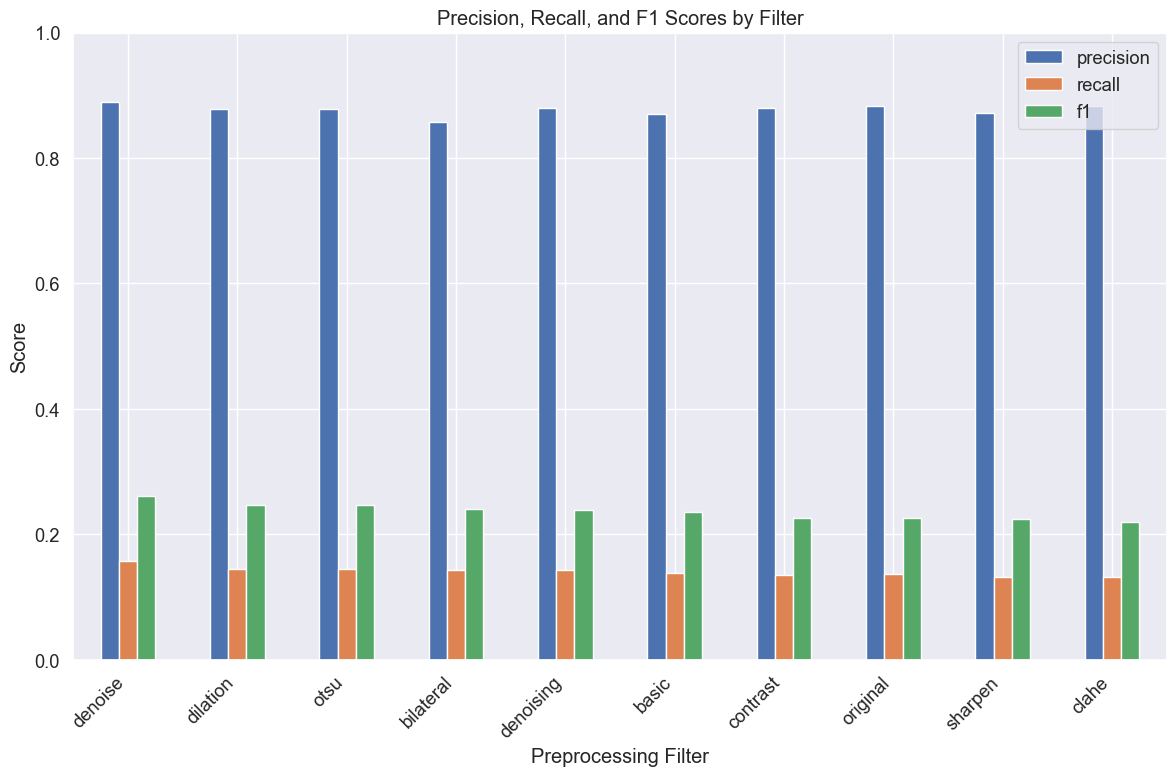

ValueError: s must be a scalar, or float array-like with the same size as x and y

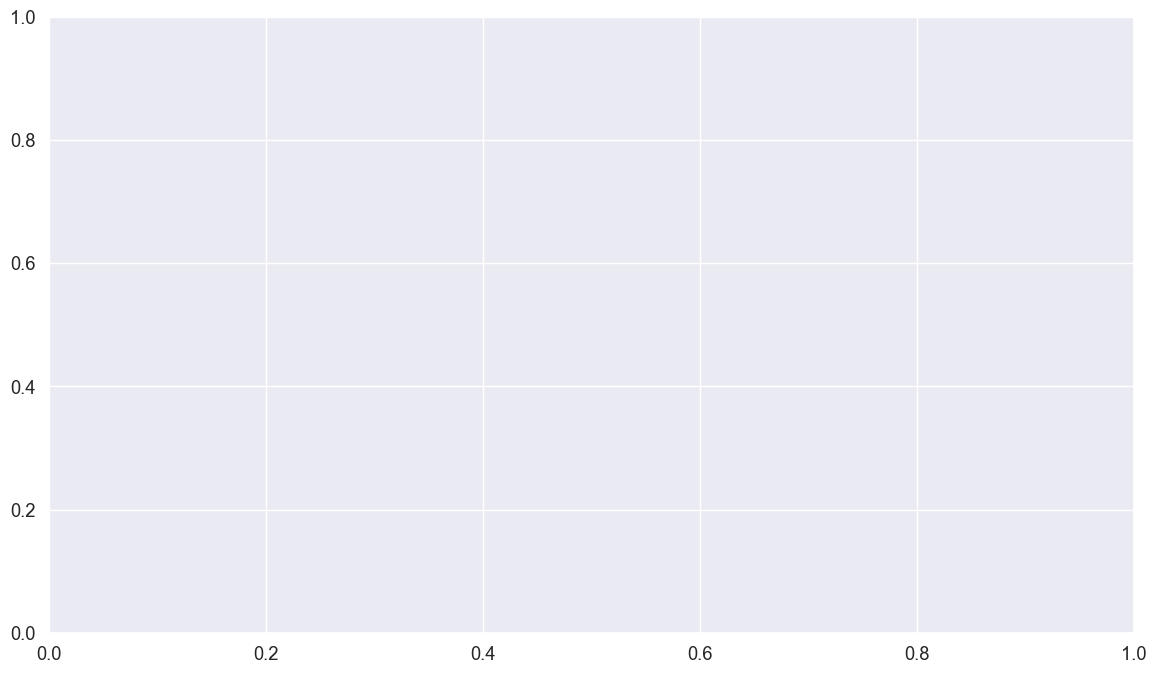

In [7]:
# Run the analysis
if __name__ == "__main__":
    main()

correctif imùage_folder batch 5 suppr

In [18]:
import pandas as pd
import os

# Dossiers
csv_folder = "data/batchs_csv"
image_folder = "images_folder"

# Agrégation des CSVs
csv_files = [os.path.join(csv_folder, f) for f in os.listdir(csv_folder) if f.endswith(".csv")]
df_list = [pd.read_csv(f) for f in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Obtenir tous les noms d'images cités dans les CSVs
valid_images = set(combined_df.iloc[:, 0])  # première colonne

# Supprimer les images qui ne sont pas citées
for img_file in os.listdir(image_folder):
    if img_file not in valid_images:
        os.remove(os.path.join(image_folder, img_file))

# Afficher le DataFrame final si besoin
print(combined_df.head())


                             image_name     category    subcategory
0       image_659698_product_822774.jpg  PlayStation       Jeux PS1
1     image_54547530_product_929584.jpg    PC Gaming        Jeux PC
2    image_62369530_product_2242928.jpg         SEGA         Autres
3  image_283812671_product_15511645.jpg  PlayStation       Jeux PS2
4  image_848934197_product_80184781.jpg     Nintendo  Jeux Game Boy


transformer les images logo de webpb en jpg 

In [6]:
from PIL import Image
import os

# Dossier contenant les images .webp
input_folder = "logo_folder"  # <-- modifie ici
output_folder = input_folder  # tu peux changer si tu veux séparer

# Crée le dossier de sortie s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Parcours de tous les fichiers du dossier
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".webp"):
        input_path = os.path.join(input_folder, filename)

        # Nom du fichier sans extension
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]
        output_filename = base_name + ".jpg"
        output_path = os.path.join(output_folder, output_filename)

        # Ouverture et conversion
        with Image.open(input_path) as img:
            img.convert("RGB").save(output_path, "JPEG")
            print(f"Converti : {filename} → {output_filename}")


Converti : 14-300x169.png.webp → 14-300x169.jpg
Converti : 15-300x169.png.webp → 15-300x169.jpg
Converti : 16-300x169.png.webp → 16-300x169.jpg
Converti : 2560px-Mega_Drive_Logo.svg-300x61.png.webp → 2560px-Mega_Drive_Logo.svg-300x61.jpg
Converti : 2560px-NES_logo.svg-300x127.png.webp → 2560px-NES_logo.svg-300x127.jpg
Converti : Dreamcast_logo.svg-300x221.png.webp → Dreamcast_logo.svg-300x221.jpg
Converti : DS-300x46.png.webp → DS-300x46.jpg
Converti : GameBoyAdvance-300x35.png.webp → GameBoyAdvance-300x35.jpg
Converti : gameboycolor-300x123.png.webp → gameboycolor-300x123.jpg
Converti : gamecube-300x69.png.webp → gamecube-300x69.jpg
Converti : Histoire-du-logo-PlayStation-e1642546714154.jpg.webp → Histoire-du-logo-PlayStation-e1642546714154.jpg
Converti : N64-300x278.png.webp → N64-300x278.jpg
Converti : nintendo-3ds.jpg.webp → nintendo-3ds.jpg
Converti : Sega-Logo-1975-1982-650x366-1-300x169.jpg.webp → Sega-Logo-1975-1982-650x366-1-300x169.jpg
Converti : Sega-Logo-1982-present-650x36

In [9]:
import cv2
import os
import numpy as np

def detect_logo_in_cover(cover_img, logo_img, ratio_test=0.75, min_match_count=10):
    """
    Détecte si une image 'logo_img' est présente dans 'cover_img' en utilisant ORB et le ratio test.
    Retourne True et les coordonnées de l'homographie si le logo est trouvé, False sinon.
    
    :param cover_img: Image de la pochette (numpy array, BGR ou GRAY)
    :param logo_img:  Image du logo (numpy array, BGR ou GRAY)
    :param ratio_test:  Seuil pour le ratio test (Lowe's ratio)
    :param min_match_count: Nombre de correspondances minimum pour considérer le logo comme détecté
    :return: (found, corners) 
             - found: bool, True si le logo a été détecté
             - corners: liste de points (4 points) correspondant aux coins déformés du logo dans la pochette
    """
    # Convertir en niveaux de gris si nécessaire
    if len(cover_img.shape) == 3:
        cover_gray = cv2.cvtColor(cover_img, cv2.COLOR_BGR2GRAY)
    else:
        cover_gray = cover_img
        
    if len(logo_img.shape) == 3:
        logo_gray = cv2.cvtColor(logo_img, cv2.COLOR_BGR2GRAY)
    else:
        logo_gray = logo_img

    # Initialiser l'extracteur de caractéristiques ORB
    orb = cv2.ORB_create()

    # Détecter et extraire les descripteurs
    kp1, des1 = orb.detectAndCompute(logo_gray, None)
    kp2, des2 = orb.detectAndCompute(cover_gray, None)

    if des1 is None or des2 is None:
        return False, None

    # On utilise BFMatcher ou un matcher basé sur la distance Hamming (pour ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # Trouver les correspondances kNN
    matches = bf.knnMatch(des1, des2, k=2)

    # Appliquer le ratio test de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)

    # Vérifier si on a suffisamment de bons matches
    if len(good_matches) > min_match_count:
        # Récupérer les points correspondants
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        # Calculer l'homographie
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            # Récupérer les dimensions de l'image du logo
            h, w = logo_gray.shape
            corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
            # Appliquer la matrice de transformation pour localiser le logo dans la pochette
            transformed_corners = cv2.perspectiveTransform(corners, M)
            return True, transformed_corners
    return False, None

def main():
    # Dossiers à modifier selon votre environnement
    covers_folder = "images_folder"  # Pochettes
    logos_folder  = "logo_folder"      # Logos

    # Liste des images covers
    covers_files = [f for f in os.listdir(covers_folder) 
                    if os.path.isfile(os.path.join(covers_folder, f))]
    # Liste des images logos
    logos_files = [f for f in os.listdir(logos_folder) 
                   if os.path.isfile(os.path.join(logos_folder, f))]

    # Créer un dossier de sortie pour stocker les résultats
    output_folder = "resultats_detection"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Parcourir chaque image de pochette
    for cover_file in covers_files:
        cover_path = os.path.join(covers_folder, cover_file)
        cover_img = cv2.imread(cover_path)

        # Pour chaque logo, tester la détection
        for logo_file in logos_files:
            logo_path = os.path.join(logos_folder, logo_file)
            logo_img = cv2.imread(logo_path)

            found, corners = detect_logo_in_cover(cover_img, logo_img, ratio_test=0.75, min_match_count=10)
            
            if found and corners is not None:
                # Dessiner un polygone sur la pochette pour illustrer l'emplacement du logo
                pts = np.int32(corners)
                cv2.polylines(cover_img, [pts], True, (0, 255, 0), 3)

                print(f"Logo '{logo_file}' détecté dans '{cover_file}'.")

        # Sauvegarder l'image de la pochette (avec éventuellement un polygone si un logo a été détecté)
        result_path = os.path.join(output_folder, cover_file)
        cv2.imwrite(result_path, cover_img)

if __name__ == "__main__":
    main()


Logo '14-300x169.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo '2560px-NES_logo.svg-300x127.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo 'switch-300x300.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo '15-300x169.jpg' détecté dans 'image_1027961004_product_578256383.jpg'.
Logo 'N64-300x278.jpg' détecté dans 'image_1053519738_product_1033730640.jpg'.
Logo '15-300x169.jpg' détecté dans 'image_1062523736_product_301815907.jpg'.
Logo 'N64-300x278.jpg' détecté dans 'image_1062523736_product_301815907.jpg'.
Logo 'nintendo-3ds.jpg' détecté dans 'image_1100064150_product_1711734470.jpg'.
Logo 'wii-300x131.jpg' détecté dans 'image_1100064150_product_1711734470.jpg'.
Logo '14-300x169.jpg' détecté dans 'image_1100081021_product_1711736636.jpg'.
Logo 'wii-300x131.jpg' détecté dans 'image_1100081021_product_1711736636.jpg'.
Logo 'Histoire-du-logo-PlayStation-e1642546714154.jpg' détecté dans 'image_1100086947_product_1711736338.jpg'.
Logo '15-3

In [ ]:
import cv2
import os
import csv
import numpy as np

def detect_logo_in_cover(cover_img, logo_img, ratio_test=0.75, min_match_count=10):
    """
    Détecte si une image 'logo_img' est présente dans 'cover_img' en utilisant ORB et le ratio test.
    Retourne un booléen found et la liste de corners (coordonnées) si le logo est détecté.
    
    :param cover_img: Image de la pochette (numpy array, BGR ou GRAY)
    :param logo_img:  Image du logo (numpy array, BGR ou GRAY)
    :param ratio_test:  Seuil pour le ratio test (Lowe's ratio)
    :param min_match_count: Nombre de correspondances minimum pour considérer le logo comme détecté
    :return: (found, corners) 
             - found: bool, True si le logo a été détecté
             - corners: liste de points (4 points) correspondant aux coins déformés du logo dans la pochette
    """
    # Convertir en niveaux de gris si nécessaire
    if len(cover_img.shape) == 3:
        cover_gray = cv2.cvtColor(cover_img, cv2.COLOR_BGR2GRAY)
    else:
        cover_gray = cover_img
        
    if len(logo_img.shape) == 3:
        logo_gray = cv2.cvtColor(logo_img, cv2.COLOR_BGR2GRAY)
    else:
        logo_gray = logo_img

    # Initialiser l'extracteur de caractéristiques ORB
    orb = cv2.ORB_create()

    # Détecter et extraire les descripteurs
    kp1, des1 = orb.detectAndCompute(logo_gray, None)
    kp2, des2 = orb.detectAndCompute(cover_gray, None)

    # S'il n'y a pas de descripteurs, retour direct
    if des1 is None or des2 is None:
        return False, None

    # On utilise BFMatcher (distance Hamming pour ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    # Trouver les correspondances kNN
    matches = bf.knnMatch(des1, des2, k=2)

    # Appliquer le ratio test de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)

    # Vérifier si on a suffisamment de bons matches
    if len(good_matches) > min_match_count:
        # Récupérer les points correspondants
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        # Calculer l'homographie
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            # Récupérer les dimensions de l'image du logo
            h, w = logo_gray.shape
            corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
            # Appliquer la matrice de transformation pour localiser le logo dans la pochette
            transformed_corners = cv2.perspectiveTransform(corners, M)
            return True, transformed_corners
    return False, None

def main():
    # À modifier selon vos chemins
    covers_folder = "images_folder"  # Pochettes
    logos_folder  = "logo_folder"      # Logos

    # Récupérer la liste des fichiers (assurez-vous qu'ils sont bien des images)
    covers_files = [f for f in os.listdir(covers_folder) 
                    if os.path.isfile(os.path.join(covers_folder, f))]
    logos_files = [f for f in os.listdir(logos_folder) 
                   if os.path.isfile(os.path.join(logos_folder, f))]

    # Créer un dossier de sortie pour les images annotées
    output_folder = "resultats_detection"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ouvrir un fichier CSV pour enregistrer les résultats
    csv_filename = "resultats_detection.csv"
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        # En-tête du CSV
        writer.writerow(["cover_file", "logo_file", "found", "corners"])

        # Parcourir chaque image de pochette
        for cover_file in covers_files:
            cover_path = os.path.join(covers_folder, cover_file)
            cover_img = cv2.imread(cover_path)

            # Vérification que l'image s'est bien chargée
            if cover_img is None:
                print(f"Impossible de lire la pochette : {cover_path}")
                continue

            # Pour chaque logo, tester la détection
            for logo_file in logos_files:
                logo_path = os.path.join(logos_folder, logo_file)
                logo_img = cv2.imread(logo_path)

                # Vérification que le logo s'est bien chargé
                if logo_img is None:
                    print(f"Impossible de lire le logo : {logo_path}")
                    continue

                found, corners = detect_logo_in_cover(cover_img, logo_img, ratio_test=0.75, min_match_count=10)

                # Écrire les résultats dans le CSV (corners sous forme de liste ou None)
                if corners is not None:
                    corners_list = corners.reshape(-1, 2).tolist()  # conversion numpy -> liste Python
                else:
                    corners_list = None
                writer.writerow([cover_file, logo_file, found, corners_list])

                # Si trouvé, dessiner un polygone sur l'image de couverture
                if found and corners is not None:
                    pts = np.int32(corners)
                    cv2.polylines(cover_img, [pts], True, (0, 255, 0), 3)
                    

            # Sauvegarder l'image de la pochette annotée
            result_path = os.path.join(output_folder, cover_file)
            cv2.imwrite(result_path, cover_img)

    print(f"Traitement terminé. Les résultats sont enregistrés dans '{csv_filename}'.")

if __name__ == "__main__":
    main()


Logo '14-300x169.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo '2560px-NES_logo.svg-300x127.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo 'switch-300x300.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo '15-300x169.jpg' détecté dans 'image_1027961004_product_578256383.jpg'.
Logo 'N64-300x278.jpg' détecté dans 'image_1053519738_product_1033730640.jpg'.
Logo '15-300x169.jpg' détecté dans 'image_1062523736_product_301815907.jpg'.
Logo 'N64-300x278.jpg' détecté dans 'image_1062523736_product_301815907.jpg'.
Logo 'nintendo-3ds.jpg' détecté dans 'image_1100064150_product_1711734470.jpg'.
Logo 'wii-300x131.jpg' détecté dans 'image_1100064150_product_1711734470.jpg'.
Logo '14-300x169.jpg' détecté dans 'image_1100081021_product_1711736636.jpg'.
Logo 'wii-300x131.jpg' détecté dans 'image_1100081021_product_1711736636.jpg'.
Logo 'Histoire-du-logo-PlayStation-e1642546714154.jpg' détecté dans 'image_1100086947_product_1711736338.jpg'.
Logo '15-3

In [12]:
import cv2
import os
import csv
import numpy as np

def detect_logo_in_cover(cover_img, logo_img, ratio_test=0.75, min_match_count=10):
    """
    Détecte si une image 'logo_img' est présente dans 'cover_img' en utilisant ORB et le ratio test.
    Retourne un booléen found et la liste de corners (coordonnées) si le logo est détecté.
    
    :param cover_img: Image de la pochette (numpy array, BGR ou GRAY)
    :param logo_img:  Image du logo (numpy array, BGR ou GRAY)
    :param ratio_test:  Seuil pour le ratio test (Lowe's ratio)
    :param min_match_count: Nombre de correspondances minimum pour considérer le logo comme détecté
    :return: (found, corners) 
             - found: bool, True si le logo a été détecté
             - corners: liste de points (4 points) correspondant aux coins déformés du logo dans la pochette
    """
    # Convertir en niveaux de gris si nécessaire
    if len(cover_img.shape) == 3:
        cover_gray = cv2.cvtColor(cover_img, cv2.COLOR_BGR2GRAY)
    else:
        cover_gray = cover_img
        
    if len(logo_img.shape) == 3:
        logo_gray = cv2.cvtColor(logo_img, cv2.COLOR_BGR2GRAY)
    else:
        logo_gray = logo_img

    # Initialiser l'extracteur de caractéristiques ORB
    orb = cv2.ORB_create()

    # Détecter et extraire les descripteurs
    kp1, des1 = orb.detectAndCompute(logo_gray, None)
    kp2, des2 = orb.detectAndCompute(cover_gray, None)

    # S'il n'y a pas de descripteurs, on ne peut pas matcher
    if des1 is None or des2 is None:
        return False, None

    # On utilise BFMatcher (distance Hamming pour ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    # Trouver les correspondances kNN
    matches = bf.knnMatch(des1, des2, k=2)

    # Appliquer le ratio test de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)

    # Vérifier si on a suffisamment de bons matches
    if len(good_matches) > min_match_count:
        # Récupérer les points correspondants
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        # Calculer l'homographie
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            # Récupérer les dimensions de l'image du logo
            h, w = logo_gray.shape
            corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
            # Appliquer la matrice de transformation pour localiser le logo dans la pochette
            transformed_corners = cv2.perspectiveTransform(corners, M)
            return True, transformed_corners
    return False, None

def main():
    # À modifier selon vos chemins
    covers_folder = "images_folder"  # Pochettes
    logos_folder  = "logo_folder"      # Logos

    # Récupérer la liste des fichiers (assurez-vous qu'ils sont bien des images)
    covers_files = [f for f in os.listdir(covers_folder) 
                    if os.path.isfile(os.path.join(covers_folder, f))]
    logos_files = [f for f in os.listdir(logos_folder) 
                   if os.path.isfile(os.path.join(logos_folder, f))]

    # Créer un dossier de sortie pour les images annotées
    output_folder = "resultats_detection"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Nom du fichier CSV de sortie
    csv_filename = "resultats_detection.csv"
    
    # Ouvrir le fichier CSV pour enregistrer les résultats
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        # En-tête du CSV
        writer.writerow(["cover_file", "logo_file", "found", "corners"])

        # Parcourir chaque image de pochette
        for cover_file in covers_files:
            cover_path = os.path.join(covers_folder, cover_file)
            cover_img = cv2.imread(cover_path)

            # Vérification que l'image s'est bien chargée
            if cover_img is None:
                print(f"Impossible de lire la pochette : {cover_path}")
                continue

            # Pour chaque logo, tester la détection
            for logo_file in logos_files:
                logo_path = os.path.join(logos_folder, logo_file)
                logo_img = cv2.imread(logo_path)

                # Vérification que le logo s'est bien chargé
                if logo_img is None:
                    print(f"Impossible de lire le logo : {logo_path}")
                    continue

                found, corners = detect_logo_in_cover(cover_img, logo_img, ratio_test=0.75, min_match_count=10)

                # Si le logo est détecté, on enregistre dans le CSV et on dessine le polygone
                if found and corners is not None:
                    # Écrire uniquement les enregistrements où found == True
                    corners_list = corners.reshape(-1, 2).tolist()  # conversion numpy -> liste Python
                    writer.writerow([cover_file, logo_file, found, corners_list])

                    # Dessiner le polygone sur l'image de couverture
                    pts = np.int32(corners)
                    cv2.polylines(cover_img, [pts], True, (0, 255, 0), 3)
                    print(f"Logo '{logo_file}' détecté dans '{cover_file}'.")

            # Sauvegarder l'image de la pochette annotée
            result_path = os.path.join(output_folder, cover_file)
            cv2.imwrite(result_path, cover_img)

    print(f"Traitement terminé. Les détections positives sont enregistrées dans '{csv_filename}'.")

if __name__ == "__main__":
    main()


Logo '14-300x169.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo '2560px-NES_logo.svg-300x127.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo 'switch-300x300.jpg' détecté dans 'image_1027902744_product_577491837.jpg'.
Logo '15-300x169.jpg' détecté dans 'image_1027961004_product_578256383.jpg'.
Logo 'N64-300x278.jpg' détecté dans 'image_1053519738_product_1033730640.jpg'.
Logo '15-300x169.jpg' détecté dans 'image_1062523736_product_301815907.jpg'.
Logo 'N64-300x278.jpg' détecté dans 'image_1062523736_product_301815907.jpg'.
Logo 'nintendo-3ds.jpg' détecté dans 'image_1100064150_product_1711734470.jpg'.
Logo 'wii-300x131.jpg' détecté dans 'image_1100064150_product_1711734470.jpg'.
Logo '14-300x169.jpg' détecté dans 'image_1100081021_product_1711736636.jpg'.
Logo 'wii-300x131.jpg' détecté dans 'image_1100081021_product_1711736636.jpg'.
Logo 'Histoire-du-logo-PlayStation-e1642546714154.jpg' détecté dans 'image_1100086947_product_1711736338.jpg'.
Logo '15-3

In [ ]:
import cv2
import os
import csv
import numpy as np

# -------------------------------------------------------------------------
# 1) Fonction de prétraitement
# -------------------------------------------------------------------------
def preprocess_image(img, 
                     desired_width=600, 
                     desired_height=600, 
                     use_clahe=True):
    """
    Convertit une image BGR en niveaux de gris, 
    la redimensionne et améliore son contraste via CLAHE si souhaité.

    :param img: image en BGR (numpy array)
    :param desired_width: largeur cible
    :param desired_height: hauteur cible
    :param use_clahe: bool, True pour appliquer la normalisation d'histogramme CLAHE
    :return: image prétraitée (numpy array, niveaux de gris)
    """
    # 1) Conversion en niveaux de gris
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # 2) Redimensionnement simple (déformation possible, à adapter si besoin de préserver le ratio)
    resized = cv2.resize(gray, (desired_width, desired_height), interpolation=cv2.INTER_AREA)

    # 3) Amélioration du contraste (optionnelle)
    if use_clahe:
        # Création d'un objet CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        processed = clahe.apply(resized)
    else:
        processed = resized

    return processed


def detect_logo_in_cover(cover_img, logo_img, 
                         ratio_test=0.75, 
                         min_match_count=10, 
                         nfeatures_orb=1000):
    """
    Détecte si une image 'logo_img' est présente dans 'cover_img' en utilisant ORB et le ratio test.
    Retourne un booléen found et la liste de corners (coordonnées) si le logo est détecté.
    
    :param cover_img: Image de la pochette (numpy array, BGR)
    :param logo_img:  Image du logo (numpy array, BGR)
    :param ratio_test:  Seuil pour le ratio test (Lowe's ratio)
    :param min_match_count: Nombre de correspondances minimum pour considérer le logo comme détecté
    :param nfeatures_orb: Nombre de features à détecter via ORB (plus c'est élevé, plus c'est lent mais complet)
    :return: (found, corners) 
             - found: bool, True si le logo a été détecté
             - corners: liste de points (4 points) correspondant aux coins du logo dans la pochette
    """
    # --- Prétraitement des images --- #
    # Vous pouvez ajuster les paramètres en fonction de vos tests
    cover_prep = preprocess_image(cover_img, desired_width=600, desired_height=600, use_clahe=True)
    logo_prep  = preprocess_image(logo_img,  desired_width=200, desired_height=200, use_clahe=True)

    # Initialiser l'extracteur de caractéristiques ORB
    orb = cv2.ORB_create(nfeatures=nfeatures_orb)

    # Détecter et extraire les descripteurs
    kp1, des1 = orb.detectAndCompute(logo_prep, None)
    kp2, des2 = orb.detectAndCompute(cover_prep, None)

    # Si pas de descripteurs, on abandonne
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return False, None

    # Matching : BFMatcher (distance Hamming pour ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)

    # Ratio test de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)

    # Vérifier si on a suffisamment de bons matches
    if len(good_matches) > min_match_count:
        # Récupérer les points correspondants
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        # Calculer l'homographie
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            # Récupérer les dimensions de l'image du logo prétraité
            # (attention, c'est la version redimensionnée/CLAHE)
            h, w = logo_prep.shape
            corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)

            transformed_corners = cv2.perspectiveTransform(corners, M)
            return True, transformed_corners
    return False, None


def main():
    # Dossiers à adapter à votre environnement
    covers_folder = "images_folder"  # Pochettes
    logos_folder  = "logo_folder"      # Logos*
    

    # Récupérer la liste des fichiers
    covers_files = [f for f in os.listdir(covers_folder) if os.path.isfile(os.path.join(covers_folder, f))]
    logos_files  = [f for f in os.listdir(logos_folder)  if os.path.isfile(os.path.join(logos_folder, f))]

    # Dossier de sortie pour les images annotées
    output_folder = "resultats_detection"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Nom du CSV de sortie
    csv_filename = "resultats_detection.csv"
    
    # Ouvrir le CSV pour enregistrer UNIQUEMENT les détections positives
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["cover_file", "logo_file", "found", "corners"])  # en-tête

        # Parcourir chaque pochette
        for cover_file in covers_files:
            cover_path = os.path.join(covers_folder, cover_file)
            cover_img = cv2.imread(cover_path)

            if cover_img is None:
                print(f"Impossible de lire la pochette : {cover_path}")
                continue

            # Copie pour dessiner les polygones détectés
            cover_display = cover_img.copy()

            # Pour chaque logo, détecter la présence
            for logo_file in logos_files:
                logo_path = os.path.join(logos_folder, logo_file)
                logo_img = cv2.imread(logo_path)

                if logo_img is None:
                    print(f"Impossible de lire le logo : {logo_path}")
                    continue

                found, corners = detect_logo_in_cover(
                    cover_display, 
                    logo_img,
                    ratio_test=0.75,
                    min_match_count=10,
                    nfeatures_orb=3000  # augmenter le nombre de features
                )

                if found and corners is not None:
                    # Écriture dans le CSV (uniquement si found == True)
                    corners_list = corners.reshape(-1, 2).tolist()
                    writer.writerow([cover_file, logo_file, found, corners_list])

                    # Dessiner le polygone sur l'image (pour qu'on voie le résultat final)
                    pts = np.int32(corners)
                    cv2.polylines(cover_display, [pts], True, (0, 255, 0), 3)
                    print(f"[DETECTION] Logo '{logo_file}' détecté dans '{cover_file}'")

            # Sauvegarder l'image de la pochette annotée
            result_path = os.path.join(output_folder, cover_file)
            cv2.imwrite(result_path, cover_display)

    print(f"\nTerminé. Les détections positives sont enregistrées dans '{csv_filename}'.\n")


if __name__ == "__main__":
    main()


[DETECTION] Logo 'Dreamcast_logo.svg-300x221.jpg' détecté dans 'image_1000493202_product_353771692.jpg'
[DETECTION] Logo 'WiiU-300x89.jpg' détecté dans 'image_1000493202_product_353771692.jpg'
[DETECTION] Logo 'wii-300x131.jpg' détecté dans 'image_1004469307_product_299520596.jpg'
[DETECTION] Logo 'Histoire-du-logo-PlayStation-e1642546714154.jpg' détecté dans 'image_1007197561_product_433282926.jpg'
[DETECTION] Logo 'WiiU-300x89.jpg' détecté dans 'image_1007197561_product_433282926.jpg'
[DETECTION] Logo 'WiiU-300x89.jpg' détecté dans 'image_1015191942_product_478836161.jpg'
[DETECTION] Logo 'Dreamcast_logo.svg-300x221.jpg' détecté dans 'image_1016066453_product_493545596.jpg'
[DETECTION] Logo 'WiiU-300x89.jpg' détecté dans 'image_1016066453_product_493545596.jpg'
[DETECTION] Logo 'wii-300x131.jpg' détecté dans 'image_1016068251_product_493900151.jpg'
[DETECTION] Logo 'WiiU-300x89.jpg' détecté dans 'image_1016068251_product_493900151.jpg'
[DETECTION] Logo 'WiiU-300x89.jpg' détecté dans 

In [28]:
import cv2
import os
import csv
import numpy as np

# -------------------------------------------------------------------------
# 1) Functions for preprocessing and cover detection
# -------------------------------------------------------------------------
def preprocess_image(img, 
                     desired_width=600, 
                     desired_height=600, 
                     use_clahe=True):
    """
    Converts a BGR image to grayscale, resizes it and enhances contrast using CLAHE if desired.

    :param img: BGR image (numpy array)
    :param desired_width: target width
    :param desired_height: target height
    :param use_clahe: bool, True to apply CLAHE histogram normalization
    :return: preprocessed image (numpy array, grayscale)
    """
    # 1) Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # 2) Simple resize (possible distortion, adjust if need to preserve ratio)
    resized = cv2.resize(gray, (desired_width, desired_height), interpolation=cv2.INTER_AREA)

    # 3) Contrast enhancement (optional)
    if use_clahe:
        # Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        processed = clahe.apply(resized)
    else:
        processed = resized

    return processed


def detect_cover_rectangle(img):
    """
    Detects the main rectangular region in an image that likely contains the video game cover.
    
    :param img: Original image (BGR)
    :return: (x, y, w, h) coordinates of the detected rectangle or None if not found
             and the masked image showing only the cover area
    """
    # Create a copy to work with
    working_img = img.copy()
    h, w = img.shape[:2]
    
    # Convert to grayscale
    gray = cv2.cvtColor(working_img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area and find the largest rectangles
    min_area = (w * h) * 0.1  # At least 10% of the image area
    max_area = (w * h) * 0.9  # At most 90% of the image area
    
    rectangle_contours = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Approximate the contour to get a simplified polygon
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Check if it's rectangular (4 corners) or close enough (4-6 corners)
            if 4 <= len(approx) <= 6:
                # Get bounding rectangle
                x, y, w, h = cv2.boundingRect(approx)
                
                # Check aspect ratio (typical video game covers are approximately 1:1.4)
                aspect_ratio = float(h) / w
                if 0.8 <= aspect_ratio <= 1.8:  # Allow some flexibility
                    rectangle_contours.append((x, y, w, h, area))
    
    # Sort by area (largest first)
    rectangle_contours.sort(key=lambda x: x[4], reverse=True)
    
    if rectangle_contours:
        # Get the largest rectangle
        x, y, w, h, _ = rectangle_contours[0]
        
        # Create a mask image with just the cover area
        mask = np.zeros_like(img)
        mask[y:y+h, x:x+w] = img[y:y+h, x:x+w]
        
        return (x, y, w, h), mask
    
    # If no suitable rectangle found, return None and the original image
    return None, img


def apply_image_corrections(img):
    """
    Apply various image corrections to enhance logo visibility.
    
    :param img: Input image (BGR)
    :return: Enhanced image
    """
    # Create a copy
    enhanced = img.copy()
    
    # 1. Convert to HSV for better color manipulation
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    
    # 2. Equalize the V channel (brightness)
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    
    # 3. Convert back to BGR
    enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # 4. Apply sharpening
    kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)
    
    # 5. Apply denoising
    enhanced = cv2.fastNlMeansDenoisingColored(enhanced, None, 10, 10, 7, 21)
    
    return enhanced


def detect_logo_in_cover(cover_img, logo_img, 
                         ratio_test=0.65, 
                         min_match_count=8, 
                         nfeatures_orb=3000):
    """
    Detects if a 'logo_img' is present in 'cover_img' using ORB and ratio test.
    Returns a boolean found and the list of corners (coordinates) if the logo is detected.
    
    :param cover_img: Cover image (numpy array, BGR)
    :param logo_img: Logo image (numpy array, BGR)
    :param ratio_test: Threshold for ratio test (Lowe's ratio)
    :param min_match_count: Minimum number of matches to consider the logo as detected
    :param nfeatures_orb: Number of features to detect via ORB
    :return: (found, corners) 
             - found: bool, True if logo was detected
             - corners: list of points (4 points) corresponding to the corners of the logo in the cover
    """
    # --- Preprocess images --- #
    cover_prep = preprocess_image(cover_img, desired_width=600, desired_height=600, use_clahe=True)
    logo_prep = preprocess_image(logo_img, desired_width=200, desired_height=200, use_clahe=True)

    # Initialize ORB feature extractor
    orb = cv2.ORB_create(nfeatures=nfeatures_orb, scaleFactor=1.2, nlevels=8)

    # Detect and extract descriptors
    kp1, des1 = orb.detectAndCompute(logo_prep, None)
    kp2, des2 = orb.detectAndCompute(cover_prep, None)

    # If no descriptors, abandon
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return False, None

    # Matching: BFMatcher (Hamming distance for ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)

    # Filter matches using Lowe's ratio test
    good_matches = []
    for match in matches:
        if len(match) == 2:  # Ensure we have 2 matches for ratio test
            m, n = match
            if m.distance < ratio_test * n.distance:
                good_matches.append(m)

    # Check if we have enough good matches
    if len(good_matches) > min_match_count:
        # Get corresponding points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        # Calculate homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            # Get dimensions of preprocessed logo image
            h, w = logo_prep.shape
            corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)

            transformed_corners = cv2.perspectiveTransform(corners, M)
            
            # Additional filtering: check if the detected area makes sense
            # Calculate area of the transformed logo
            polygon_area = cv2.contourArea(transformed_corners)
            
            # Reasonable area range (adjust based on your specific use case)
            min_area_threshold = 100  # Min expected logo area in pixels
            max_area_threshold = cover_prep.shape[0] * cover_prep.shape[1] * 0.5  # Max 50% of cover
            
            if min_area_threshold < polygon_area < max_area_threshold:
                return True, transformed_corners
            
    return False, None


def convert_corners_to_original_scale(corners, cover_rect, original_size, processed_size=(600, 600)):
    """
    Convert corners from the processed image scale back to the original cropped cover scale.
    
    :param corners: Detected corners in processed image
    :param cover_rect: (x, y, w, h) of the detected cover in original image
    :param original_size: Original image dimensions (height, width)
    :param processed_size: Processed image dimensions (width, height)
    :return: Corners adjusted to the original scale
    """
    if corners is None or cover_rect is None:
        return None
    
    x, y, w, h = cover_rect
    orig_w, orig_h = original_size[1], original_size[0]
    proc_w, proc_h = processed_size
    
    # Scale factors
    scale_x = w / proc_w
    scale_y = h / proc_h
    
    # Convert corners
    adjusted_corners = corners.copy()
    for i in range(adjusted_corners.shape[0]):
        adjusted_corners[i, 0, 0] = adjusted_corners[i, 0, 0] * scale_x + x
        adjusted_corners[i, 0, 1] = adjusted_corners[i, 0, 1] * scale_y + y
    
    return adjusted_corners


def main():
    # Folders to adapt to your environment
    covers_folder = "images_folder"  # Covers
    logos_folder = "logo_folder"     # Logos
    
    # Get list of files
    covers_files = [f for f in os.listdir(covers_folder) if os.path.isfile(os.path.join(covers_folder, f))]
    logos_files = [f for f in os.listdir(logos_folder) if os.path.isfile(os.path.join(logos_folder, f))]

    # Output folder for annotated images
    output_folder = "resultats_detection"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Debug folder for intermediate processing steps
    debug_folder = "debug_detection"
    if not os.path.exists(debug_folder):
        os.makedirs(debug_folder)

    # Output CSV filename
    csv_filename = "resultats_detection.csv"
    
    # Open CSV to record ONLY positive detections
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["cover_file", "logo_file", "found", "corners", "confidence"])  # header

        # Process each cover
        for cover_file in covers_files:
            cover_path = os.path.join(covers_folder, cover_file)
            original_img = cv2.imread(cover_path)

            if original_img is None:
                print(f"Unable to read cover: {cover_path}")
                continue

            # Create a copy for drawing detected polygons
            result_img = original_img.copy()
            
            # 1. Detect the main cover rectangle
            cover_rect, cover_masked = detect_cover_rectangle(original_img)
            
            # Save debug image showing detected cover
            if cover_rect:
                x, y, w, h = cover_rect
                debug_cover = original_img.copy()
                cv2.rectangle(debug_cover, (x, y), (x+w, y+h), (0, 255, 0), 3)
                cv2.imwrite(os.path.join(debug_folder, f"cover_detect_{cover_file}"), debug_cover)
                
                # Also save the masked image
                cv2.imwrite(os.path.join(debug_folder, f"masked_{cover_file}"), cover_masked)
                
                # Extract just the cover area
                cover_area = original_img[y:y+h, x:x+w]
                
                # Apply image corrections to enhance logo visibility
                enhanced_cover = apply_image_corrections(cover_area)
                cv2.imwrite(os.path.join(debug_folder, f"enhanced_{cover_file}"), enhanced_cover)
            else:
                # If no cover detected, use the whole image but apply enhancements
                enhanced_cover = apply_image_corrections(original_img)
                cover_rect = (0, 0, original_img.shape[1], original_img.shape[0])
            
            # For each logo, detect presence
            for logo_file in logos_files:
                logo_path = os.path.join(logos_folder, logo_file)
                logo_img = cv2.imread(logo_path)

                if logo_img is None:
                    print(f"Unable to read logo: {logo_path}")
                    continue
                
                # First try detection on the enhanced cover area
                found, corners = detect_logo_in_cover(
                    enhanced_cover, 
                    logo_img,
                    ratio_test=0.65,  # Slightly relaxed ratio test
                    min_match_count=8,
                    nfeatures_orb=4000  # Increased features
                )
                
                confidence = 0
                
                if found and corners is not None:
                    # Convert corners to original image coordinates
                    adjusted_corners = convert_corners_to_original_scale(
                        corners, 
                        cover_rect,
                        original_img.shape[:2]
                    )
                    
                    # Calculate match confidence (number of inliers)
                    # This is a placeholder - improve with actual confidence calculation
                    confidence = 0.8  # High confidence from enhanced detection
                    
                    # Write to CSV (only if found)
                    corners_list = adjusted_corners.reshape(-1, 2).tolist()
                    writer.writerow([cover_file, logo_file, found, corners_list, confidence])

                    # Draw polygon on the image
                    pts = np.int32(adjusted_corners)
                    cv2.polylines(result_img, [pts], True, (0, 255, 0), 3)
                    
                    # Add text label for the logo
                    x, y = pts[0, 0]  # Top-left corner
                    cv2.putText(result_img, f"{logo_file}", (x, y-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    
                    print(f"[DETECTION] Logo '{logo_file}' detected in '{cover_file}' (high confidence)")
                
                # If not found on the enhanced image, try the original image as fallback
                elif cover_rect:  # Only if we detected a cover
                    found, corners = detect_logo_in_cover(
                        original_img, 
                        logo_img,
                        ratio_test=0.7,  # More relaxed for fallback
                        min_match_count=6,
                        nfeatures_orb=5000
                    )
                    
                    if found and corners is not None:
                        # Write to CSV
                        corners_list = corners.reshape(-1, 2).tolist()
                        
                        # Lower confidence for fallback detection
                        confidence = 0.4
                        
                        writer.writerow([cover_file, logo_file, found, corners_list, confidence])

                        # Draw polygon with a different color (yellow) for fallback detection
                        pts = np.int32(corners)
                        cv2.polylines(result_img, [pts], True, (0, 255, 255), 3)
                        
                        # Add text label for the logo
                        x, y = pts[0, 0]  # Top-left corner
                        cv2.putText(result_img, f"{logo_file} (low conf)", (x, y-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                        
                        print(f"[DETECTION] Logo '{logo_file}' detected in '{cover_file}' (low confidence)")

            # Save the annotated cover image
            result_path = os.path.join(output_folder, cover_file)
            cv2.imwrite(result_path, result_img)

    print(f"\nFinished. Positive detections are recorded in '{csv_filename}'.\n")
    print(f"Debug images showing detected cover areas and preprocessing are saved in '{debug_folder}'.")


if __name__ == "__main__":
    main()

[DETECTION] Logo 'WiiU-300x89.jpg' detected in 'image_1004469307_product_299520596.jpg' (low confidence)
[DETECTION] Logo 'Histoire-du-logo-PlayStation-e1642546714154.jpg' detected in 'image_1030684872_product_602135429.jpg' (low confidence)
[DETECTION] Logo 'WiiU-300x89.jpg' detected in 'image_1032783160_product_630642988.jpg' (low confidence)
[DETECTION] Logo 'WiiU-300x89.jpg' detected in 'image_1039267141_product_646789701.jpg' (low confidence)


KeyboardInterrupt: 

In [29]:
import cv2
import os
import csv
import numpy as np

# -------------------------------------------------------------------------
# 1) Functions for preprocessing and cover detection
# -------------------------------------------------------------------------
def preprocess_image(img, 
                     desired_width=600, 
                     desired_height=600, 
                     use_clahe=True):
    """
    Converts a BGR image to grayscale, resizes it and enhances contrast using CLAHE if desired.

    :param img: BGR image (numpy array)
    :param desired_width: target width
    :param desired_height: target height
    :param use_clahe: bool, True to apply CLAHE histogram normalization
    :return: preprocessed image (numpy array, grayscale)
    """
    # 1) Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # 2) Simple resize (possible distortion, adjust if need to preserve ratio)
    resized = cv2.resize(gray, (desired_width, desired_height), interpolation=cv2.INTER_AREA)

    # 3) Contrast enhancement (optional)
    if use_clahe:
        # Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        processed = clahe.apply(resized)
    else:
        processed = resized

    return processed


def detect_cover_rectangle(img):
    """
    Detects the main rectangular region in an image that likely contains the video game cover.
    
    :param img: Original image (BGR)
    :return: (x, y, w, h) coordinates of the detected rectangle or None if not found
             and the masked image showing only the cover area
    """
    # Create a copy to work with
    working_img = img.copy()
    h, w = img.shape[:2]
    
    # Convert to grayscale
    gray = cv2.cvtColor(working_img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area and find the largest rectangles
    min_area = (w * h) * 0.1  # At least 10% of the image area
    max_area = (w * h) * 0.9  # At most 90% of the image area
    
    rectangle_contours = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Approximate the contour to get a simplified polygon
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Check if it's rectangular (4 corners) or close enough (4-6 corners)
            if 4 <= len(approx) <= 6:
                # Get bounding rectangle
                x, y, w, h = cv2.boundingRect(approx)
                
                # Check aspect ratio (typical video game covers are approximately 1:1.4)
                aspect_ratio = float(h) / w
                if 0.8 <= aspect_ratio <= 1.8:  # Allow some flexibility
                    rectangle_contours.append((x, y, w, h, area))
    
    # Sort by area (largest first)
    rectangle_contours.sort(key=lambda x: x[4], reverse=True)
    
    if rectangle_contours:
        # Get the largest rectangle
        x, y, w, h, _ = rectangle_contours[0]
        
        # Create a mask image with just the cover area
        mask = np.zeros_like(img)
        mask[y:y+h, x:x+w] = img[y:y+h, x:x+w]
        
        return (x, y, w, h), mask
    
    # If no suitable rectangle found, return None and the original image
    return None, img


def apply_image_corrections(img):
    """
    Apply various image corrections to enhance logo visibility.
    
    :param img: Input image (BGR)
    :return: Enhanced image
    """
    # Create a copy
    enhanced = img.copy()
    
    # 1. Convert to HSV for better color manipulation
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    
    # 2. Equalize the V channel (brightness)
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    
    # 3. Convert back to BGR
    enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # 4. Apply sharpening
    kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)
    
    # 5. Apply denoising
    enhanced = cv2.fastNlMeansDenoisingColored(enhanced, None, 10, 10, 7, 21)
    
    return enhanced


def detect_logo_in_cover(cover_img, logo_img, 
                         ratio_test=0.6, 
                         min_match_count=10, 
                         nfeatures_orb=3000):
    """
    Detects if a 'logo_img' is present in 'cover_img' using ORB and ratio test.
    Returns a boolean found and the list of corners (coordinates) if the logo is detected.
    
    :param cover_img: Cover image (numpy array, BGR)
    :param logo_img: Logo image (numpy array, BGR)
    :param ratio_test: Threshold for ratio test (Lowe's ratio)
    :param min_match_count: Minimum number of matches to consider the logo as detected
    :param nfeatures_orb: Number of features to detect via ORB
    :return: (found, corners) 
             - found: bool, True if logo was detected
             - corners: list of points (4 points) corresponding to the corners of the logo in the cover
    """
    # --- Preprocess images --- #
    cover_prep = preprocess_image(cover_img, desired_width=600, desired_height=600, use_clahe=True)
    logo_prep = preprocess_image(logo_img, desired_width=200, desired_height=200, use_clahe=True)

    # Initialize ORB feature extractor
    orb = cv2.ORB_create(nfeatures=nfeatures_orb, scaleFactor=1.2, nlevels=8)

    # Detect and extract descriptors
    kp1, des1 = orb.detectAndCompute(logo_prep, None)
    kp2, des2 = orb.detectAndCompute(cover_prep, None)

    # If no descriptors, abandon
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return False, None

    # Matching: BFMatcher (Hamming distance for ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)

    # Filter matches using Lowe's ratio test
    good_matches = []
    for match in matches:
        if len(match) == 2:  # Ensure we have 2 matches for ratio test
            m, n = match
            if m.distance < ratio_test * n.distance:
                good_matches.append(m)

    # Check if we have enough good matches
    if len(good_matches) > min_match_count:
        # Get corresponding points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        # Calculate homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            # Get dimensions of preprocessed logo image
            h, w = logo_prep.shape
            corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)

            transformed_corners = cv2.perspectiveTransform(corners, M)
            
            # Additional filtering: check if the detected area makes sense
            # Calculate area of the transformed logo
            polygon_area = cv2.contourArea(transformed_corners)
            
            # Reasonable area range (adjust based on your specific use case)
            min_area_threshold = 200  # Min expected logo area in pixels (increased)
            max_area_threshold = cover_prep.shape[0] * cover_prep.shape[1] * 0.4  # Max 40% of cover (reduced)
            
            # Check if the polygon shape is reasonable (not extremely elongated)
            # Calculate bounding rect and check aspect ratio
            rect = cv2.minAreaRect(transformed_corners)
            width, height = rect[1]
            if width == 0 or height == 0:
                return False, None
                
            aspect_ratio = max(width, height) / min(width, height)
            
            # Reject extremely elongated shapes (aspect ratio > 5)
            if aspect_ratio > 5:
                return False, None
                
            # Check if the polygon is not too small or too large
            if min_area_threshold < polygon_area < max_area_threshold:
                return True, transformed_corners
            
    return False, None


def convert_corners_to_original_scale(corners, cover_rect, original_size, processed_size=(600, 600)):
    """
    Convert corners from the processed image scale back to the original cropped cover scale.
    
    :param corners: Detected corners in processed image
    :param cover_rect: (x, y, w, h) of the detected cover in original image
    :param original_size: Original image dimensions (height, width)
    :param processed_size: Processed image dimensions (width, height)
    :return: Corners adjusted to the original scale
    """
    if corners is None or cover_rect is None:
        return None
    
    x, y, w, h = cover_rect
    orig_w, orig_h = original_size[1], original_size[0]
    proc_w, proc_h = processed_size
    
    # Scale factors
    scale_x = w / proc_w
    scale_y = h / proc_h
    
    # Convert corners
    adjusted_corners = corners.copy()
    for i in range(adjusted_corners.shape[0]):
        adjusted_corners[i, 0, 0] = adjusted_corners[i, 0, 0] * scale_x + x
        adjusted_corners[i, 0, 1] = adjusted_corners[i, 0, 1] * scale_y + y
    
    return adjusted_corners


def main():
    # Folders to adapt to your environment
    covers_folder = "images_folder"  # Covers
    logos_folder = "logo_folder"     # Logos
    
    # Get list of files
    covers_files = [f for f in os.listdir(covers_folder) if os.path.isfile(os.path.join(covers_folder, f))]
    logos_files = [f for f in os.listdir(logos_folder) if os.path.isfile(os.path.join(logos_folder, f))]

    # Output folder for annotated images
    output_folder = "resultats_detection"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Debug folder for intermediate processing steps
    debug_folder = "debug_detection"
    if not os.path.exists(debug_folder):
        os.makedirs(debug_folder)

    # Output CSV filename
    csv_filename = "resultats_detection.csv"
    
    # Open CSV to record ONLY positive detections
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["cover_file", "logo_file", "found", "corners", "confidence"])  # header

        # Process each cover
        for cover_file in covers_files:
            cover_path = os.path.join(covers_folder, cover_file)
            original_img = cv2.imread(cover_path)

            if original_img is None:
                print(f"Unable to read cover: {cover_path}")
                continue

            # Create a copy for drawing detected polygons
            result_img = original_img.copy()
            
            # 1. Detect the main cover rectangle
            cover_rect, cover_masked = detect_cover_rectangle(original_img)
            
            # Save debug image showing detected cover
            if cover_rect:
                x, y, w, h = cover_rect
                debug_cover = original_img.copy()
                cv2.rectangle(debug_cover, (x, y), (x+w, y+h), (0, 255, 0), 3)
                cv2.imwrite(os.path.join(debug_folder, f"cover_detect_{cover_file}"), debug_cover)
                
                # Also save the masked image
                cv2.imwrite(os.path.join(debug_folder, f"masked_{cover_file}"), cover_masked)
                
                # Extract just the cover area
                cover_area = original_img[y:y+h, x:x+w]
                
                # Apply image corrections to enhance logo visibility
                enhanced_cover = apply_image_corrections(cover_area)
                cv2.imwrite(os.path.join(debug_folder, f"enhanced_{cover_file}"), enhanced_cover)
            else:
                # If no cover detected, use the whole image but apply enhancements
                enhanced_cover = apply_image_corrections(original_img)
                cover_rect = (0, 0, original_img.shape[1], original_img.shape[0])
            
            # For each logo, detect presence
            for logo_file in logos_files:
                logo_path = os.path.join(logos_folder, logo_file)
                logo_img = cv2.imread(logo_path)

                if logo_img is None:
                    print(f"Unable to read logo: {logo_path}")
                    continue
                
                # First try detection on the enhanced cover area
                found, corners = detect_logo_in_cover(
                    enhanced_cover, 
                    logo_img,
                    ratio_test=0.6,  # Stricter ratio test for better quality matches
                    min_match_count=10,  # Increased minimum matches for better reliability
                    nfeatures_orb=4000  # Increased features
                )
                
                confidence = 0
                
                if found and corners is not None:
                    # Convert corners to original image coordinates
                    adjusted_corners = convert_corners_to_original_scale(
                        corners, 
                        cover_rect,
                        original_img.shape[:2]
                    )
                    
                    # Calculate match confidence (number of inliers)
                    # This is a placeholder - improve with actual confidence calculation
                    confidence = 0.8  # High confidence from enhanced detection
                    
                    # Write to CSV (only if found)
                    corners_list = adjusted_corners.reshape(-1, 2).tolist()
                    writer.writerow([cover_file, logo_file, found, corners_list, confidence])

                    # Draw polygon on the image
                    pts = np.int32(adjusted_corners)
                    cv2.polylines(result_img, [pts], True, (0, 255, 0), 3)
                    
                    # No text labels as requested
                    
                    print(f"[DETECTION] Logo '{logo_file}' detected in '{cover_file}' (high confidence)")
                
                # If not found on the enhanced image, try the original image as fallback
                elif cover_rect:  # Only if we detected a cover
                    found, corners = detect_logo_in_cover(
                        original_img, 
                        logo_img,
                        ratio_test=0.65,  # A bit more strict for better quality
                        min_match_count=8,  # Increase minimum matches
                        nfeatures_orb=5000
                    )
                    
                    if found and corners is not None:
                        # Write to CSV
                        corners_list = corners.reshape(-1, 2).tolist()
                        
                        # Lower confidence for fallback detection
                        confidence = 0.4
                        
                        writer.writerow([cover_file, logo_file, found, corners_list, confidence])

                        # Draw polygon with a different color (yellow) for fallback detection
                        pts = np.int32(corners)
                        cv2.polylines(result_img, [pts], True, (0, 255, 255), 3)
                        
                        # No text labels as requested
                        
                        print(f"[DETECTION] Logo '{logo_file}' detected in '{cover_file}' (low confidence)")

            # Save the annotated cover image
            result_path = os.path.join(output_folder, cover_file)
            cv2.imwrite(result_path, result_img)

    print(f"\nFinished. Positive detections are recorded in '{csv_filename}'.\n")
    print(f"Debug images showing detected cover areas and preprocessing are saved in '{debug_folder}'.")


if __name__ == "__main__":
    main()

[DETECTION] Logo 'wii-300x131.jpg' detected in 'image_1100066257_product_1711735869.jpg' (low confidence)
[DETECTION] Logo 'WiiU-300x89.jpg' detected in 'image_933245076_product_190101189.jpg' (low confidence)

Finished. Positive detections are recorded in 'resultats_detection.csv'.

Debug images showing detected cover areas and preprocessing are saved in 'debug_detection'.
